In [ ]:
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
!pip install mpl_finance
from mpl_finance import candlestick_ohlc

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from google.colab import drive
drive.mount('gdrive')
!ln -s "/content/gdrive/MyDrive/financial_news_project" "/content/financial_news_project"


Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).
ln: failed to create symbolic link '/content/financial_news_project/financial_news_project': File exists


In [ ]:
news_dataset_path='/content/financial_news_project/us_equities_news_dataset.csv'
sotcks_dataset_path="/content/financial_news_project/prices.csv"
nasdaq_index_dataset_path="/content/financial_news_project/nasdaq_index.csv"

# READ news dataframe

In [ ]:
news_dataframe = pd.read_csv(news_dataset_path, delimiter=',', engine="python", error_bad_lines=False)
nRow, nCol = news_dataframe.shape
print(f'There are {nRow} rows and {nCol} columns')
apple_news_dataframe = news_dataframe[news_dataframe["ticker"] == "AAPL"].sort_values(by=["release_date"])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 140403: field larger than field limit (131072)


There are 221562 rows and 9 columns


In [ ]:
news_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221562 entries, 0 to 221561
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            221562 non-null  object 
 1   ticker        221513 non-null  object 
 2   title         221513 non-null  object 
 3   category      221513 non-null  object 
 4   content       221505 non-null  object 
 5   release_date  221512 non-null  object 
 6   provider      221512 non-null  object 
 7   url           221512 non-null  object 
 8   article_id    221512 non-null  float64
dtypes: float64(1), object(8)
memory usage: 15.2+ MB


In [ ]:
news_dataframe

,id,ticker,title,category,content,release_date,provider,url,article_id
0,221515,NIO,Why Shares of Chinese Electric Car Maker NIO A...,news,What s happening\nShares of Chinese electric c...,2020-01-15,The Motley Fool,https://invst.ly/pigqi,2060327.0
1,221516,NIO,NIO only consumer gainer Workhorse Group amon...,news,Gainers NIO NYSE NIO 7 \nLosers MGP Ingr...,2020-01-18,Seeking Alpha,https://invst.ly/pje9c,2062196.0
2,221517,NIO,NIO leads consumer gainers Beyond Meat and Ma...,news,Gainers NIO NYSE NIO 14 Village Farms In...,2020-01-15,Seeking Alpha,https://invst.ly/pifmv,2060249.0
3,221518,NIO,NIO NVAX among premarket gainers,news,Cemtrex NASDAQ CETX 85 after FY results \n...,2020-01-15,Seeking Alpha,https://invst.ly/picu8,2060039.0
4,221519,NIO,PLUG NIO among premarket gainers,news,aTyr Pharma NASDAQ LIFE 63 on Kyorin Pharm...,2020-01-06,Seeking Alpha,https://seekingalpha.com/news/3529772-plug-nio...,2053096.0
...,...,...,...,...,...,...,...,...,...
221557,443024,T,Crude And Steel Still In Sync,opinion,We have been reporting on the trade off betwee...,2012-10-04,Ivan Kitov,https://www.investing.com/analysis/crude-and-s...,138733.0
221558,443025,T,Forget AT T This Is The Telecom Stock You Sho...,opinion,It s the largest cell phone provider in the wo...,2012-05-30,StreetAuthority,https://www.investing.com/analysis/forget-at-t...,124829.0
221559,443026,T,Wall Street Exposed Part 3 How Dividends C...,opinion,Before we dicuss how the mechanism of dividend...,2012-07-16,Portfolio Cafe,https://www.investing.com/analysis/wall-street...,129651.0
221560,443027,T,Weighing The Week Ahead It s All About Jobs,opinion,From start to finish the coming week will hav...,2012-09-02,Jeff Miller,https://www.investing.com/analysis/weighing-th...,134926.0


In [ ]:
del news_dataframe["id"], news_dataframe["article_id"]

In [ ]:
news_dataframe

,ticker,title,category,content,release_date,provider,url
0,NIO,Why Shares of Chinese Electric Car Maker NIO A...,news,What s happening\nShares of Chinese electric c...,2020-01-15,The Motley Fool,https://invst.ly/pigqi
1,NIO,NIO only consumer gainer Workhorse Group amon...,news,Gainers NIO NYSE NIO 7 \nLosers MGP Ingr...,2020-01-18,Seeking Alpha,https://invst.ly/pje9c
2,NIO,NIO leads consumer gainers Beyond Meat and Ma...,news,Gainers NIO NYSE NIO 14 Village Farms In...,2020-01-15,Seeking Alpha,https://invst.ly/pifmv
3,NIO,NIO NVAX among premarket gainers,news,Cemtrex NASDAQ CETX 85 after FY results \n...,2020-01-15,Seeking Alpha,https://invst.ly/picu8
4,NIO,PLUG NIO among premarket gainers,news,aTyr Pharma NASDAQ LIFE 63 on Kyorin Pharm...,2020-01-06,Seeking Alpha,https://seekingalpha.com/news/3529772-plug-nio...
...,...,...,...,...,...,...,...
221557,T,Crude And Steel Still In Sync,opinion,We have been reporting on the trade off betwee...,2012-10-04,Ivan Kitov,https://www.investing.com/analysis/crude-and-s...
221558,T,Forget AT T This Is The Telecom Stock You Sho...,opinion,It s the largest cell phone provider in the wo...,2012-05-30,StreetAuthority,https://www.investing.com/analysis/forget-at-t...
221559,T,Wall Street Exposed Part 3 How Dividends C...,opinion,Before we dicuss how the mechanism of dividend...,2012-07-16,Portfolio Cafe,https://www.investing.com/analysis/wall-street...
221560,T,Weighing The Week Ahead It s All About Jobs,opinion,From start to finish the coming week will hav...,2012-09-02,Jeff Miller,https://www.investing.com/analysis/weighing-th...


# READ Stocks for apple

In [ ]:
stocks_dataframe = pd.read_csv(sotcks_dataset_path, delimiter=',').sort_values(by=["date"])
nRow, nCol = stocks_dataframe.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 2537 rows and 13 columns


In [ ]:
stocks_dataframe

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2012-01-03,411.23,412.5000,409.00,409.4000,10793600,12.590405,12.629287,12.522130,12.534376,302221102,0.0,1.0
1,2012-01-04,413.44,414.6800,409.28,410.0000,9286500,12.658067,12.696031,12.530702,12.552746,260022260,0.0,1.0
2,2012-01-05,418.03,418.5500,412.67,414.9500,9688200,12.798596,12.814517,12.634492,12.704298,271269871,0.0,1.0
3,2012-01-06,422.40,422.7500,419.22,419.7700,11367600,12.932390,12.943106,12.835030,12.851869,318293118,0.0,1.0
4,2012-01-09,421.73,427.7500,421.35,425.5001,14072300,12.911877,13.096188,12.900243,13.027304,394024794,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2532,2022-01-25,159.78,162.7600,157.02,158.9800,115798367,159.780000,162.760000,157.020000,158.980000,115798367,0.0,1.0
2533,2022-01-26,159.69,164.3894,157.82,163.5000,108275308,159.690000,164.389400,157.820000,163.500000,108275308,0.0,1.0
2534,2022-01-27,159.22,163.8400,158.28,162.4500,121954638,159.220000,163.840000,158.280000,162.450000,121954638,0.0,1.0
2535,2022-01-28,170.33,170.3500,162.80,165.7100,179935660,170.330000,170.350000,162.800000,165.710000,179935660,0.0,1.0


In [ ]:
stocks_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2537 entries, 0 to 2536
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         2537 non-null   object 
 1   close        2537 non-null   float64
 2   high         2537 non-null   float64
 3   low          2537 non-null   float64
 4   open         2537 non-null   float64
 5   volume       2537 non-null   int64  
 6   adjClose     2537 non-null   float64
 7   adjHigh      2537 non-null   float64
 8   adjLow       2537 non-null   float64
 9   adjOpen      2537 non-null   float64
 10  adjVolume    2537 non-null   int64  
 11  divCash      2537 non-null   float64
 12  splitFactor  2537 non-null   float64
dtypes: float64(10), int64(2), object(1)
memory usage: 277.5+ KB


In [ ]:
stocks_dataframe.describe()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
count,2537.000000,2537.000000,2537.000000,2537.000000,2.537000e+03,2537.000000,2537.000000,2537.000000,2537.000000,2.537000e+03,2537.000000,2537.000000
mean,250.915518,253.320444,248.378656,250.891585,4.160561e+07,48.249074,48.734621,47.724440,48.223562,2.139322e+08,0.015940,1.003547
std,171.161508,172.809266,169.461266,171.291837,3.382803e+07,40.691363,41.155037,40.186037,40.663091,1.755573e+08,0.176683,0.133161
min,90.280000,90.700000,89.470000,90.000000,5.704900e+06,12.132997,12.414784,11.964298,12.053463,4.099995e+07,0.000000,1.000000
25%,122.540000,123.870000,121.260000,122.600000,2.014360e+07,21.329153,21.515267,21.150665,21.382969,1.023867e+08,0.000000,1.000000
50%,170.330000,171.790000,168.910000,170.160000,3.120358e+07,29.782098,30.104936,29.637220,29.889168,1.494495e+08,0.000000,1.000000
75%,388.230000,394.000000,384.250000,387.970000,5.113552e+07,53.155034,53.774128,52.431952,53.007516,2.631885e+08,0.000000,1.000000
max,702.100000,705.070000,699.570000,702.410000,3.326072e+08,182.010000,182.940000,179.120000,182.630000,1.506122e+09,3.290000,7.000007


# READ Nasdaq Index Data

In [ ]:
nasdaq_index_dataframe = pd.read_csv(nasdaq_index_dataset_path, delimiter=',').sort_values(by=["Date"])
nRow, nCol = nasdaq_index_dataframe.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 2556 rows and 7 columns


In [ ]:
nasdaq_index_dataframe

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,2657.389893,2665.899902,2641.979980,2648.719971,2648.719971,1636850000
1,2012-01-04,2639.899902,2653.179932,2627.229980,2648.360107,2648.360107,1670530000
2,2012-01-05,2642.570068,2673.560059,2631.229980,2669.860107,2669.860107,1836410000
3,2012-01-06,2671.169922,2682.120117,2658.830078,2674.219971,2674.219971,1683090000
4,2012-01-09,2682.979980,2683.780029,2662.959961,2676.560059,2676.560059,1768080000
...,...,...,...,...,...,...,...
2551,2022-02-22,13424.360352,13618.719727,13249.650391,13381.519531,13381.519531,4830920000
2552,2022-02-23,13511.750000,13533.780273,13032.169922,13037.490234,13037.490234,4614090000
2553,2022-02-24,12587.879883,13486.110352,12587.879883,13473.589844,13473.589844,6131410000
2554,2022-02-25,13485.259766,13696.860352,13358.290039,13694.620117,13694.620117,4614110000


In [ ]:
nasdaq_index_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556 entries, 0 to 2555
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2556 non-null   object 
 1   Open       2556 non-null   float64
 2   High       2556 non-null   float64
 3   Low        2556 non-null   float64
 4   Close      2556 non-null   float64
 5   Adj Close  2556 non-null   float64
 6   Volume     2556 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 159.8+ KB


In [ ]:
nasdaq_index_dataframe.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2.556000e+03
mean,6816.981417,6857.769817,6770.996966,6817.979748,6817.979748,2.493151e+09
std,3456.455142,3481.412571,3425.717483,3455.522876,3455.522876,1.261110e+09
min,2639.899902,2653.179932,2627.229980,2648.360107,2648.360107,1.494100e+08
25%,4368.582520,4384.674805,4342.997314,4368.520142,4368.520142,1.763928e+09
50%,5652.619873,5664.474853,5639.114990,5655.760010,5655.760010,1.992920e+09
75%,8039.402344,8071.117676,7982.077515,8025.874878,8025.874878,2.498978e+09
max,16120.919922,16212.230469,16017.230469,16057.440430,16057.440430,1.110216e+10


**Renaming nasdaq_index_dataframe columns to match columns of apple_stocks_dataframe**

In [ ]:
nasdaq_index_dataframe = nasdaq_index_dataframe.rename(columns={'Date': 'date', 'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low', 'Adj Close':'adjClose', 'Volume':'volume'})

# The Nasdaq index over time

This graph descripes the movement of stock market over the years, from 2011 up 2021

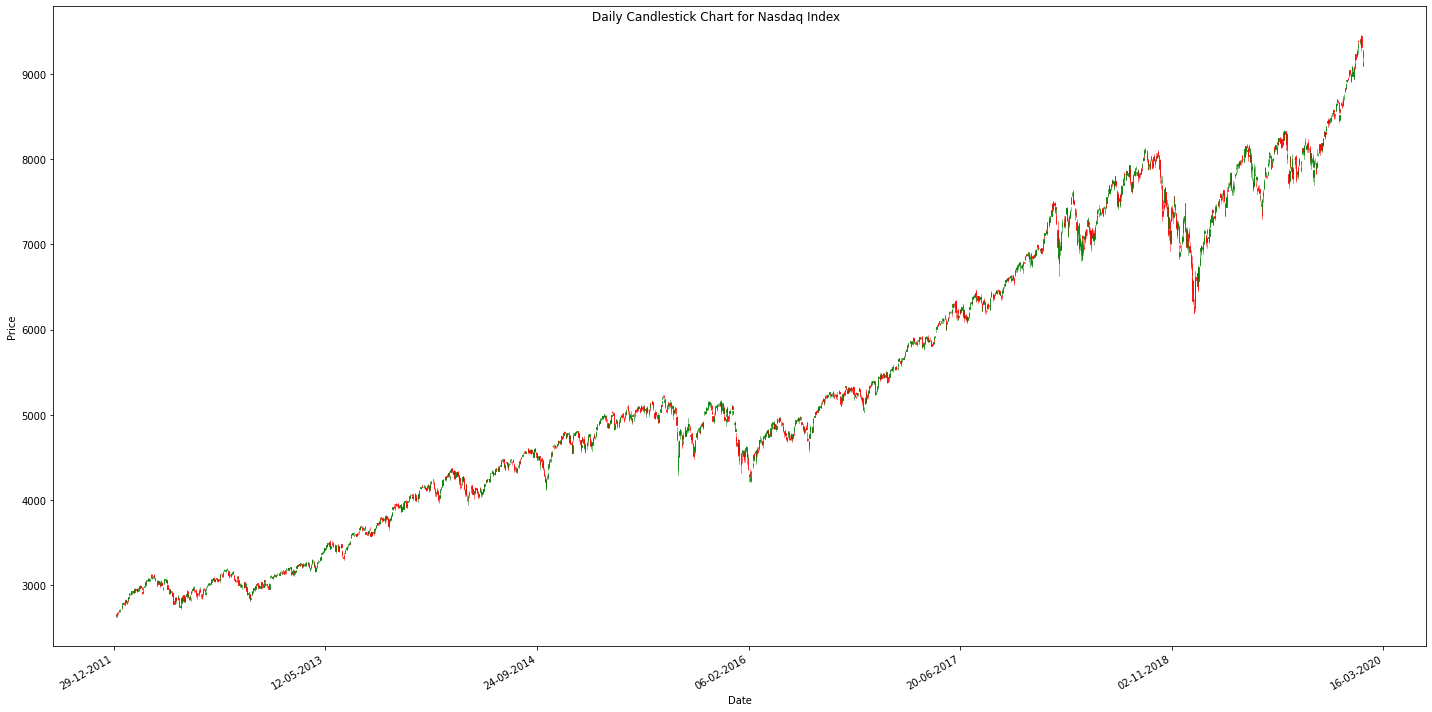

In [ ]:
nohlc = nasdaq_index_dataframe.loc[:, ['date', 'open', 'high', 'low', 'close', 'volume']]
nasdaq_index_dataframe = nasdaq_index_dataframe[nasdaq_index_dataframe["date"] <= "2020-01-28"]
nohlc = nohlc[nohlc["date"] <= "2020-01-28"]
nohlc['date'] = pd.to_datetime(nohlc['date'])
nohlc['date'] = nohlc['date'].apply(mpl_dates.date2num)
nohlc = nohlc.astype(float)

# Creating Subplots
fig, ax = plt.subplots()

candlestick_ohlc(ax, nohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
fig.set_size_inches((20, 10))
# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('Daily Candlestick Chart for Nasdaq Index')

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()

plt.show()

# The daily volume of stocks in Nasdaq 

volume of stocks traded in Nasdaq market over the years

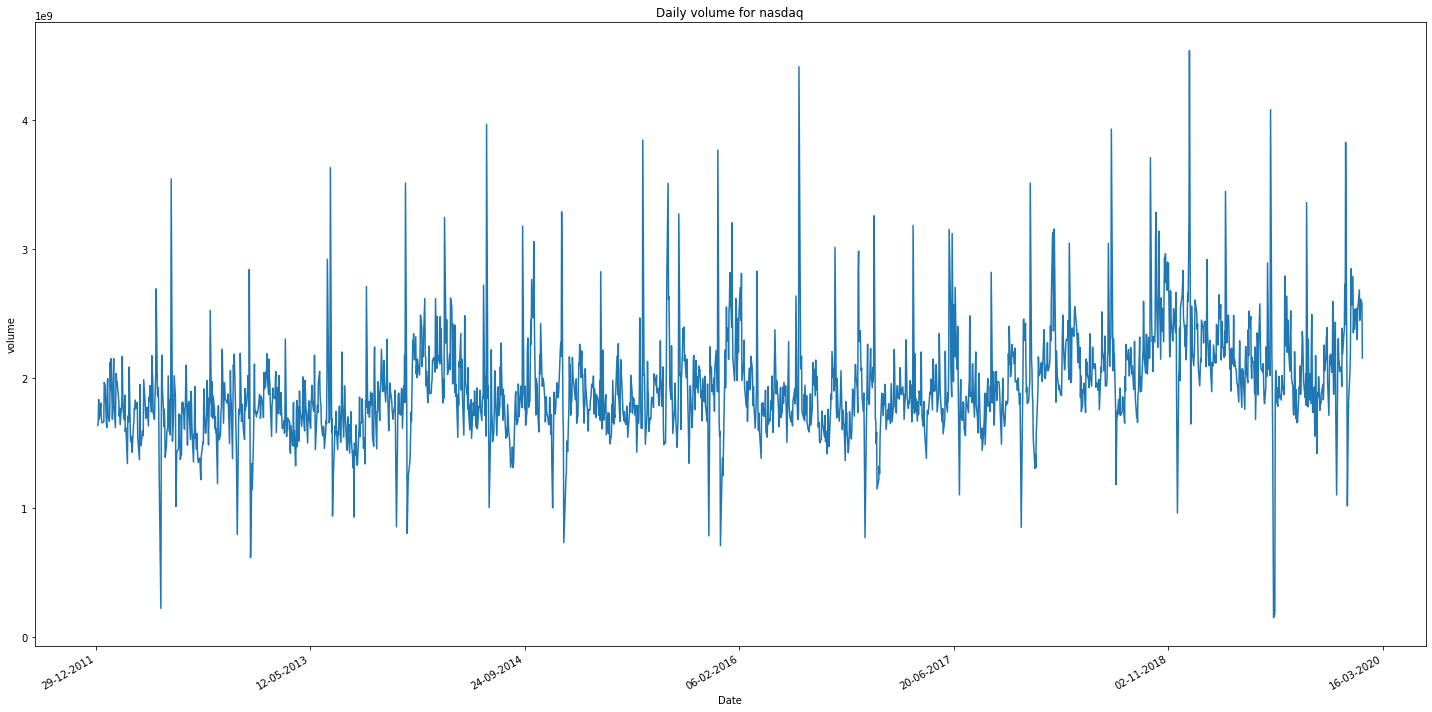

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('volume')
plt.title('Daily volume for nasdaq')
ax.plot(nohlc["date"], nohlc["volume"])
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

# Yearly mean and median of volume for nasdaq

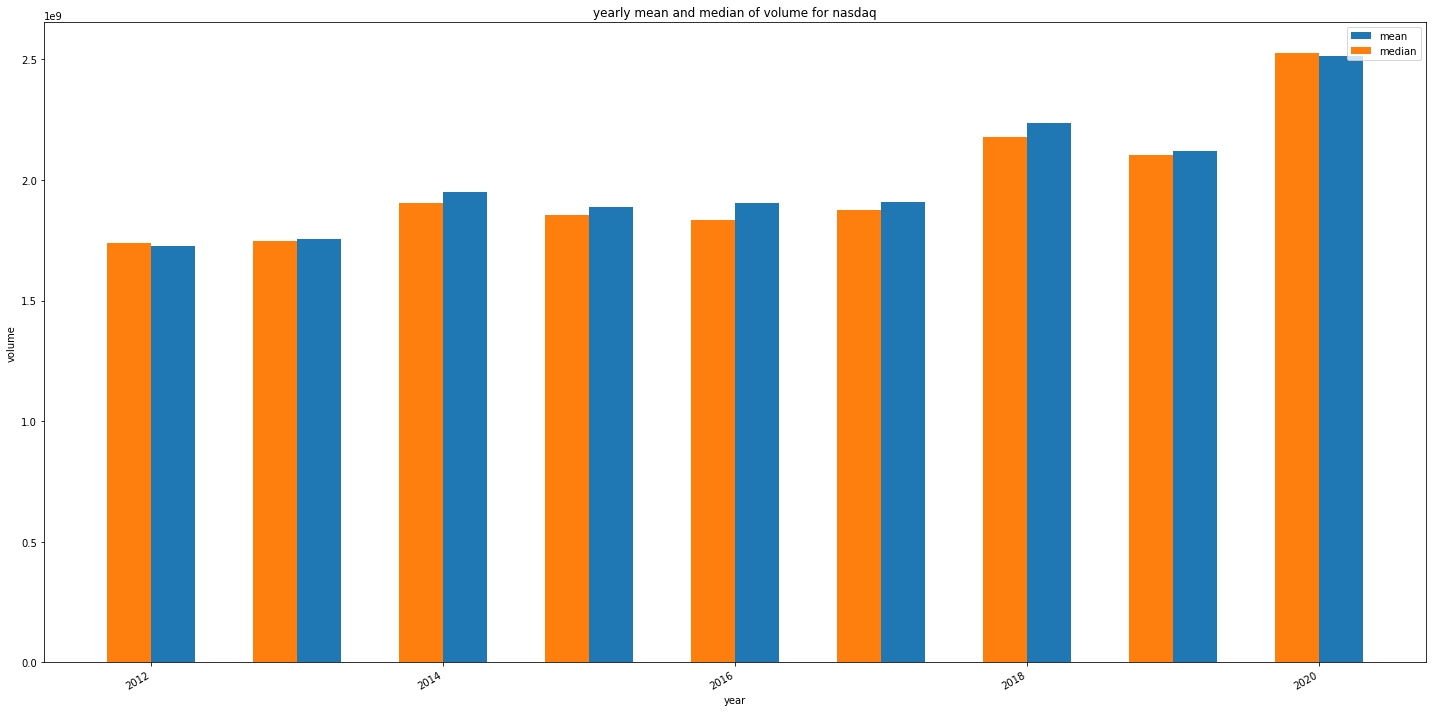

In [ ]:
nasdaq_index_dataframe['date'] = pd.to_datetime(nasdaq_index_dataframe['date']) 
nasdaq_index_dataframe['quarter'] = nasdaq_index_dataframe['date'].dt.to_period('Q')
res = nasdaq_index_dataframe.groupby([nasdaq_index_dataframe.date.dt.year]).agg({"volume": [np.mean, np.median], "close":[np.mean, np.median]})
res.reset_index(inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
ax.set_xlabel('year')
ax.set_ylabel('volume')
plt.title('yearly mean and median of volume for nasdaq')
res = res.sort_values(by="date")
ax.bar(res['date'], res["volume"]["mean"], align='edge', width=0.3, label="mean")
ax.bar(res['date'], res["volume"]["median"], align='edge', width=-0.3, label="median")
plt.legend(loc="upper right")
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

# Yearly mean and median of close price for nasdaq

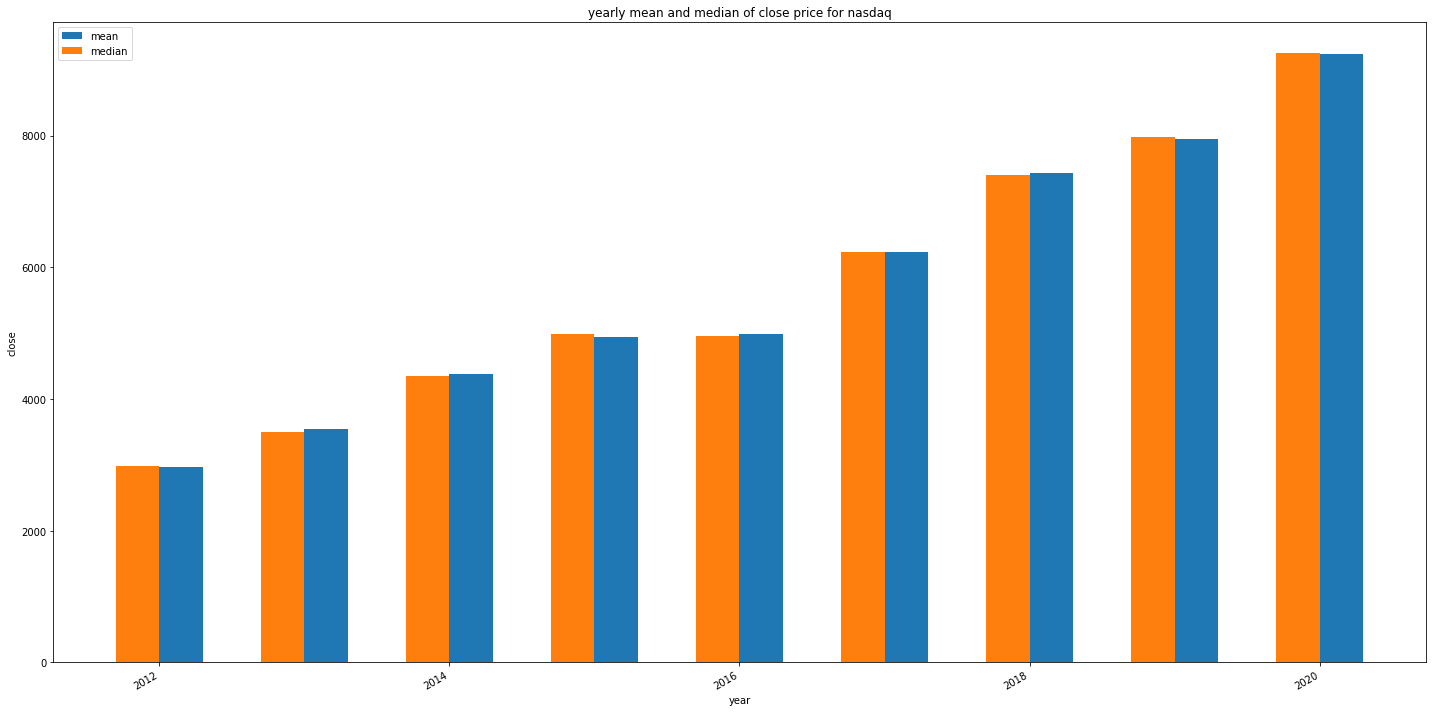

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
ax.set_xlabel('year')
ax.set_ylabel('close')
plt.title('yearly mean and median of close price for nasdaq')
ax.bar(res['date'], res["close"]["mean"], align='edge', width=0.3, label="mean")
ax.bar(res['date'], res["close"]["median"], align='edge', width=-0.3, label="median")
plt.legend(loc="upper left")
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

# The trend of apple price over the time, the gaps shows the stock split that apple did. 

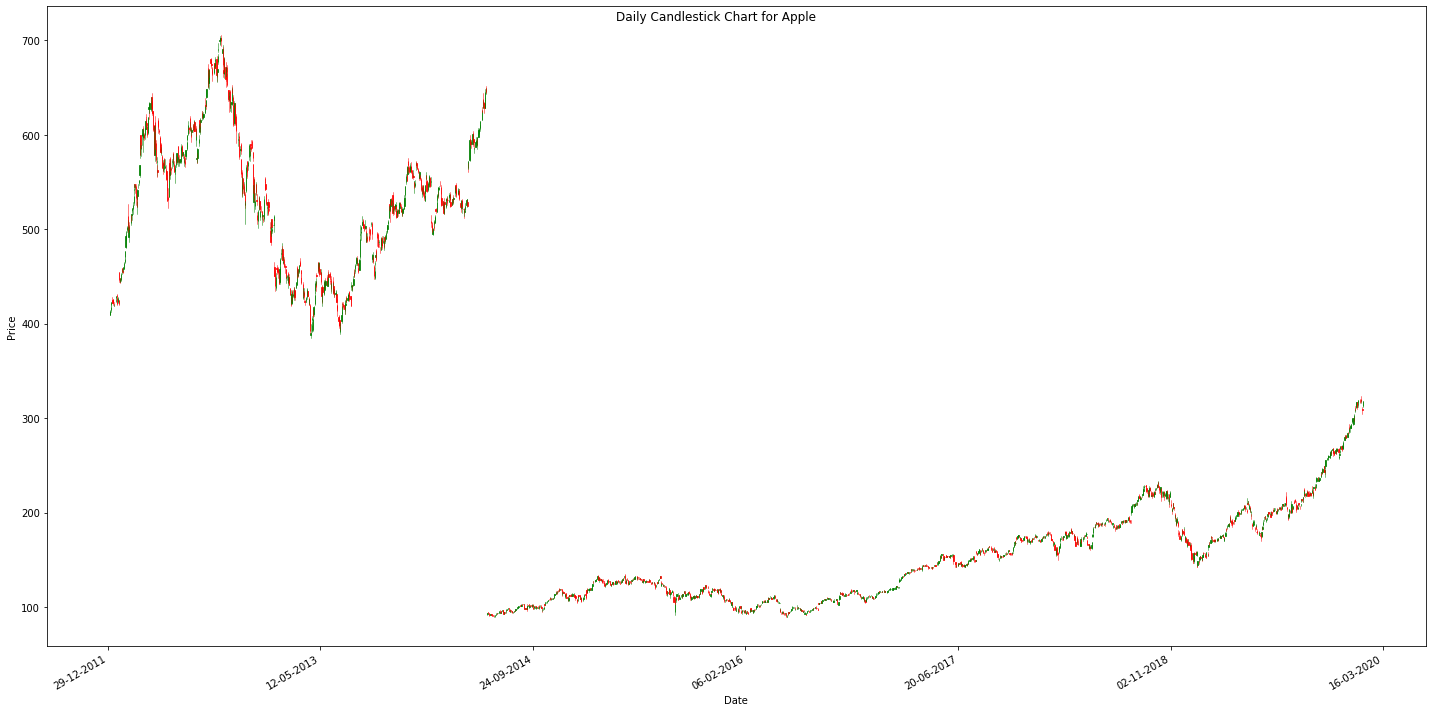

In [ ]:
stocks_dataframe = stocks_dataframe[stocks_dataframe["date"] <= "2020-01-28"]
ohlc = stocks_dataframe.loc[:, ['date', 'open', 'high', 'low', 'close', 'volume']]
ohlc['date'] = pd.to_datetime(ohlc['date'])
ohlc['date'] = ohlc['date'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)

# Creating Subplots
fig, ax = plt.subplots()

candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
fig.set_size_inches((20, 10))
# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('Daily Candlestick Chart for Apple')
# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()

plt.show()

In 2014-06-09	a 7 for 1 stock split has been done, the price of the stock changed from 633 dollar to 92 dollar.
In general apple stock is following the Nasdaq trend

**Check the date and the value of the split fcator**

In [ ]:
stocks_dataframe[stocks_dataframe["splitFactor"] != 1]

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
610,2014-06-09,93.7,93.88,91.75,92.7,75414997,21.01074,21.051103,20.573484,20.786506,301659988,0.0,7.000007


# The daily Volume for Apple stock


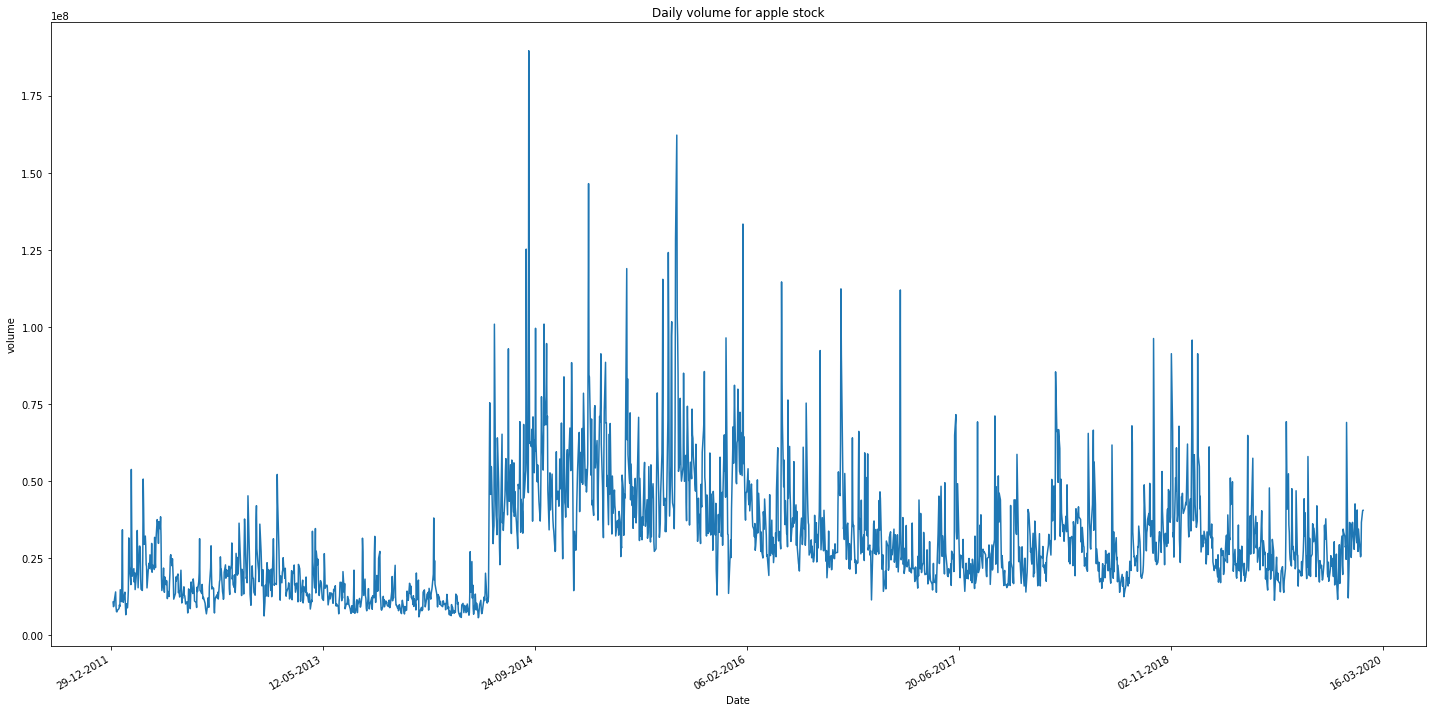

In [ ]:
fig, ax = plt.subplots()
plt.title('Daily volume for apple stock')
fig.set_size_inches((20, 10))
ax.set_xlabel('Date')
ax.set_ylabel('volume')
ax.plot(ohlc["date"], ohlc["volume"])
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

Notice the increase of the trade of apple's stock after 2014-06-09, casued by the stock split that happened in this date.

# Yearly mean and median of volume for apple

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


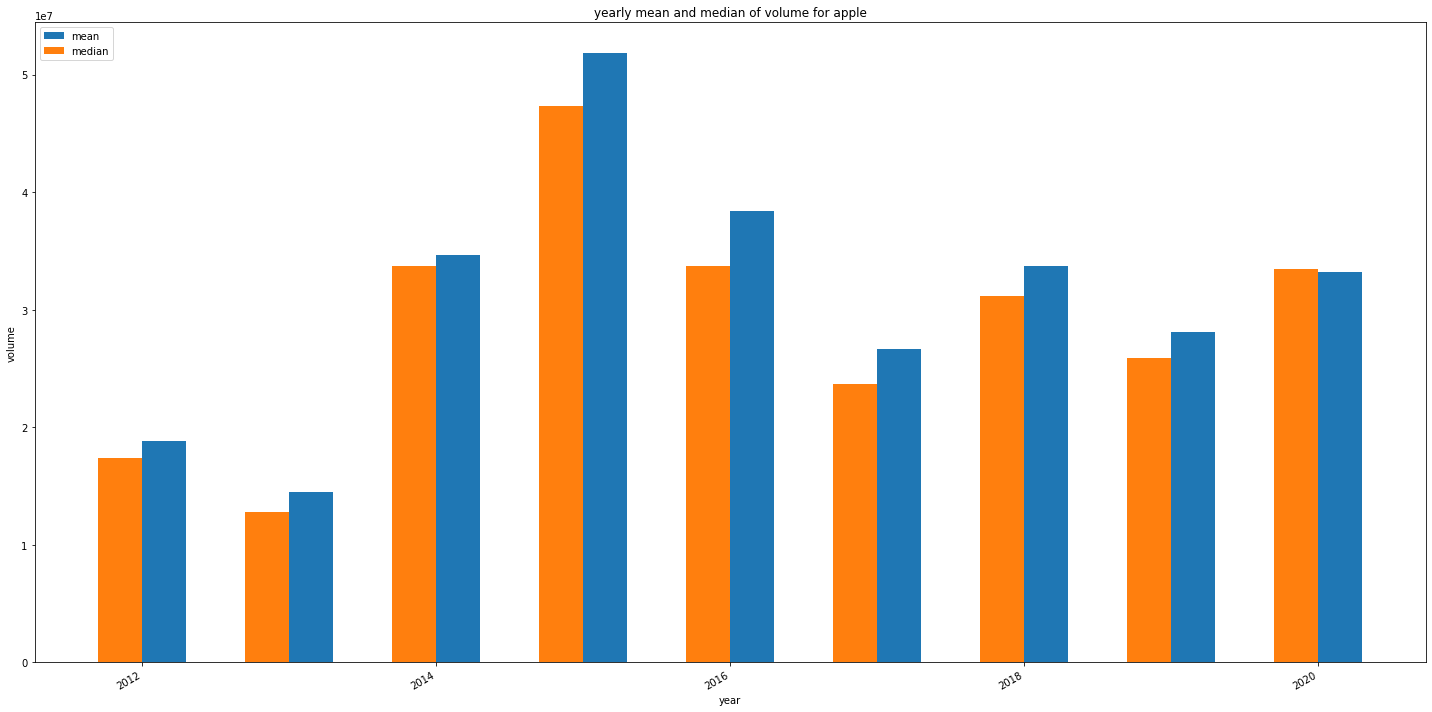

In [ ]:
stocks_dataframe['date'] = pd.to_datetime(stocks_dataframe['date']) 
stocks_dataframe['quarter'] = stocks_dataframe['date'].dt.to_period('Q')
res = stocks_dataframe.groupby([stocks_dataframe.date.dt.year]).agg({"volume": [np.mean, np.median], "close":[np.mean, np.median]})
res.reset_index(inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
ax.set_xlabel('year')
ax.set_ylabel('volume')
plt.title('yearly mean and median of volume for apple')
res = res.sort_values(by="date")
ax.bar(res['date'], res["volume"]["mean"], align='edge', width=0.3, label="mean")
ax.bar(res['date'], res["volume"]["median"], align='edge', width=-0.3, label="median")
plt.legend(loc="upper left")
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

# Yearly mean and median of close price for apple stock

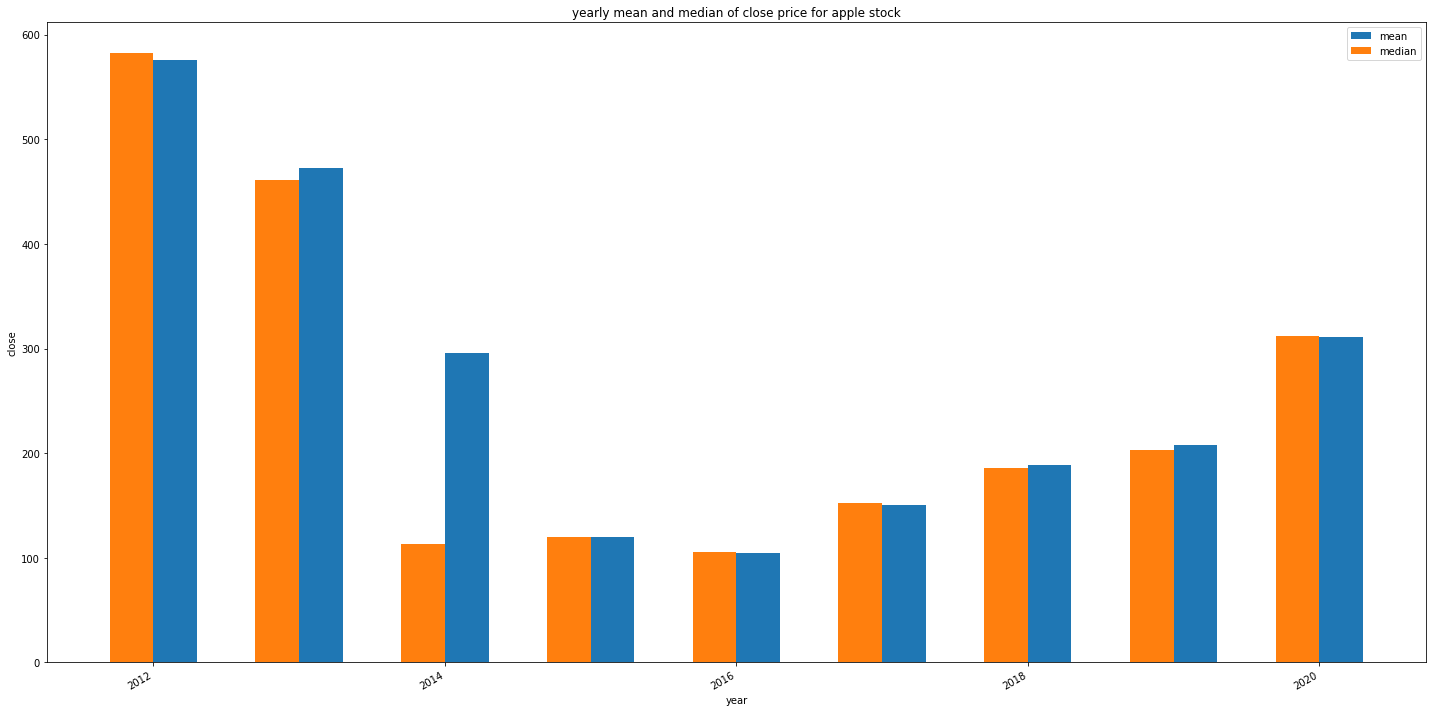

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
ax.set_xlabel('year')
ax.set_ylabel('close')
plt.title('yearly mean and median of close price for apple stock')
ax.bar(res['date'], res["close"]["mean"], align='edge', width=0.3, label="mean")
ax.bar(res['date'], res["close"]["median"], align='edge', width=-0.3, label="median")
plt.legend(loc="upper right")
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

# Create stocks diff column

In [ ]:
stocks_diff = stocks_dataframe["close"].diff()
stocks_diff = stocks_diff.fillna(0)
stocks_dataframe["stocks_diff"] = stocks_diff
stocks_dataframe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor,quarter,stocks_diff
0,2012-01-03,411.23,412.50,409.00,409.4000,10793600,12.590405,12.629287,12.522130,12.534376,302221102,0.0,1.0,2012Q1,0.00
1,2012-01-04,413.44,414.68,409.28,410.0000,9286500,12.658067,12.696031,12.530702,12.552746,260022260,0.0,1.0,2012Q1,2.21
2,2012-01-05,418.03,418.55,412.67,414.9500,9688200,12.798596,12.814517,12.634492,12.704298,271269871,0.0,1.0,2012Q1,4.59
3,2012-01-06,422.40,422.75,419.22,419.7700,11367600,12.932390,12.943106,12.835030,12.851869,318293118,0.0,1.0,2012Q1,4.37
4,2012-01-09,421.73,427.75,421.35,425.5001,14072300,12.911877,13.096188,12.900243,13.027304,394024794,0.0,1.0,2012Q1,-0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025,2020-01-22,317.70,319.99,317.31,318.5800,25458115,78.261597,78.825711,78.165525,78.478375,101832460,0.0,1.0,2020Q1,1.13
2026,2020-01-23,319.23,319.56,315.65,317.9200,26117993,78.638494,78.719786,77.756604,78.315792,104471972,0.0,1.0,2020Q1,1.53
2027,2020-01-24,318.31,323.33,317.52,320.2500,36634380,78.411863,79.648480,78.217256,78.889759,146537520,0.0,1.0,2020Q1,-0.92
2028,2020-01-27,308.95,311.77,304.88,310.0600,40485005,76.106139,76.800813,75.103543,76.379575,161940020,0.0,1.0,2020Q1,-9.36


In [ ]:
stocks_dataframe[stocks_dataframe["splitFactor"] != 1]

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor,quarter,stocks_diff
610,2014-06-09,93.7,93.88,91.75,92.7,75414997,21.01074,21.051103,20.573484,20.786506,301659988,0.0,7.000007,2014Q2,-551.87


In [ ]:
stocks_dataframe.loc[stocks_dataframe["splitFactor"] != 1, "stocks_diff"] = 0
stocks_dataframe[stocks_dataframe["splitFactor"] != 1]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor,quarter,stocks_diff
610,2014-06-09,93.7,93.88,91.75,92.7,75414997,21.01074,21.051103,20.573484,20.786506,301659988,0.0,7.000007,2014Q2,0.0


# The monthly prices increase or decrease in the apple stock 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


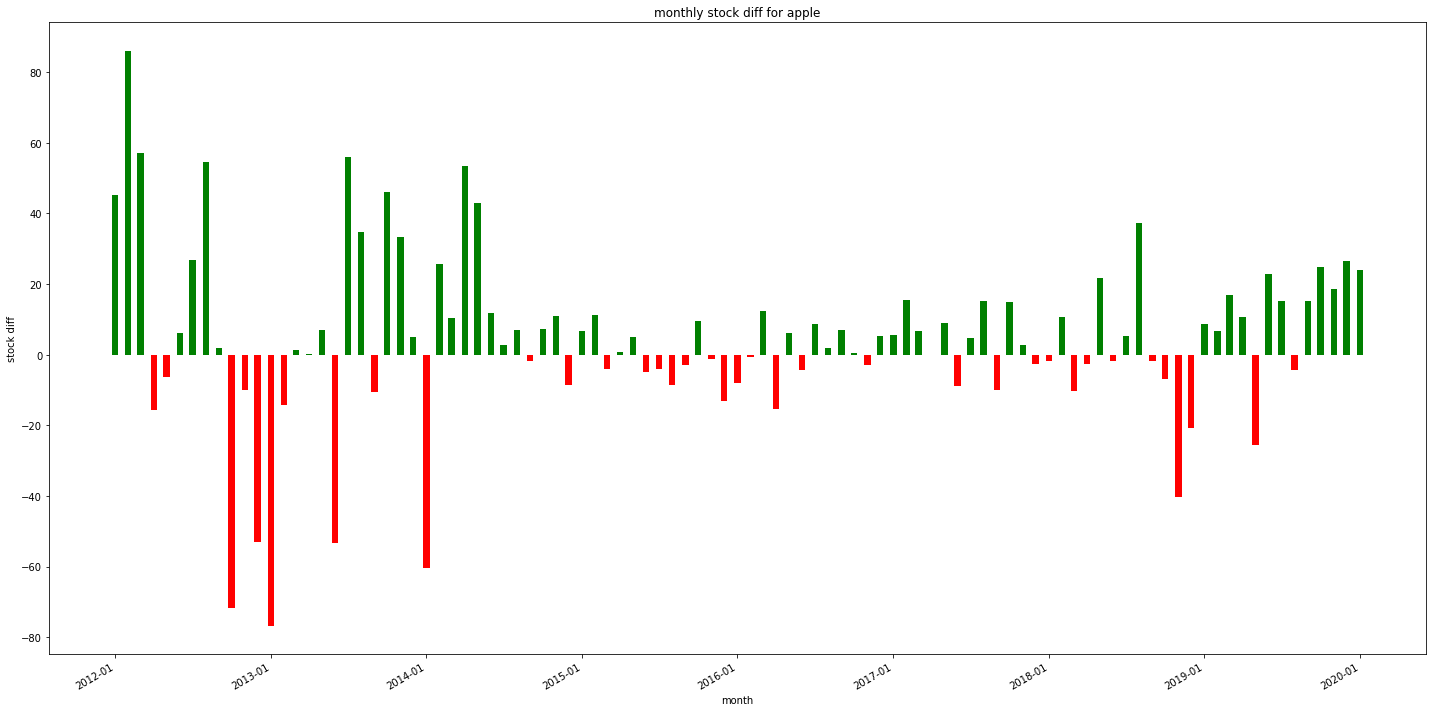

In [ ]:
stocks_dataframe['date'] = pd.to_datetime(stocks_dataframe['date']) 
res = stocks_dataframe.groupby([stocks_dataframe.date.dt.month, stocks_dataframe.date.dt.year]).sum("stocks_diff")
res = res.rename_axis(['month', 'year'])
res.reset_index(inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
# Setting labels & titles
ax.set_xlabel('month')
ax.set_ylabel('stock diff')
plt.title('monthly stock diff for apple')
res = res.astype({"month": str, "year": str})
res["date"] = res["year"] + "-" + res["month"]
res['date'] = pd.to_datetime(res['date'])
color = (res["stocks_diff"] > 0).map({True: 'g', False: 'r'})
ax.bar(res['date'], res["stocks_diff"], width=15, color=color)
date_format = mpl_dates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

# The quarterly volume of Nasdaq in the market. 

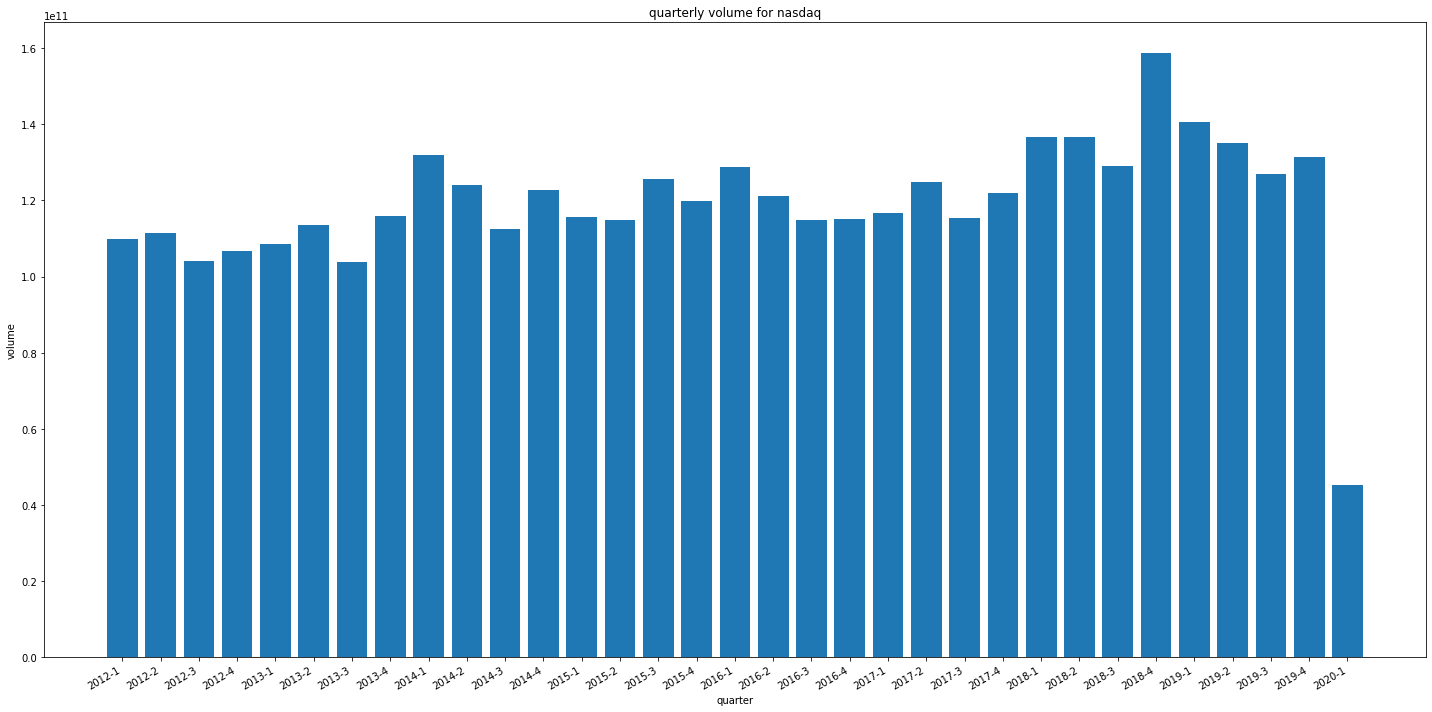

In [ ]:
nasdaq_index_dataframe['date'] = pd.to_datetime(nasdaq_index_dataframe['date']) 
nasdaq_index_dataframe['quarter'] = nasdaq_index_dataframe['date'].dt.to_period('Q')
res = nasdaq_index_dataframe.groupby([nasdaq_index_dataframe.date.dt.quarter, nasdaq_index_dataframe.date.dt.year]).sum("volume")
res = res.rename_axis(['quarter', 'year'])
res.reset_index(inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
# Setting labels & titles
ax.set_xlabel('quarter')
ax.set_ylabel('volume')
plt.title('quarterly volume for nasdaq')
res = res.astype({"quarter": str, "year": str})
res["date"] = res["year"] + "-" + res["quarter"]
res = res.sort_values(by="date")
# res['date'] = pd.to_datetime(res['date'])
ax.bar(res['date'], res["volume"])
# date_format = mpl_dates.DateFormatter('%Y')
# ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

# The quarterly close price of Nasdaq in the market. 

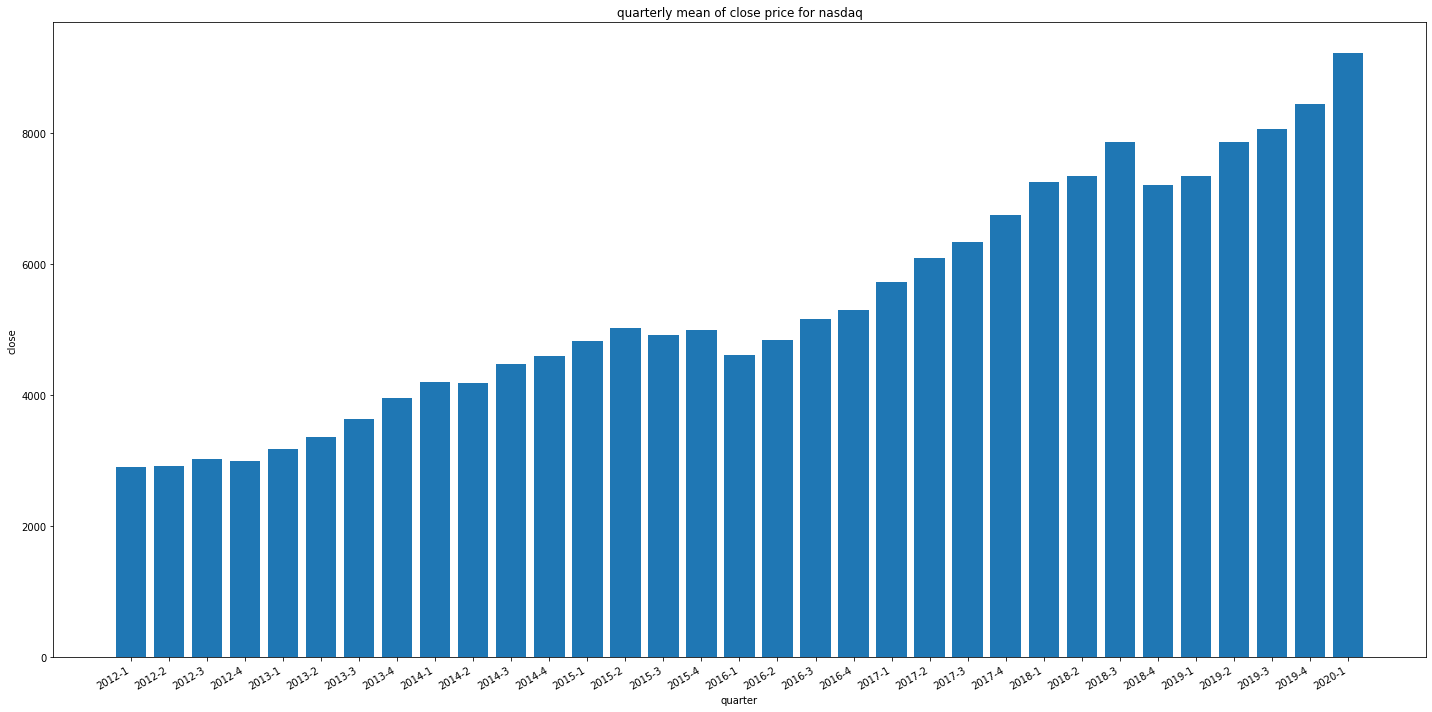

In [ ]:
nasdaq_index_dataframe['date'] = pd.to_datetime(nasdaq_index_dataframe['date']) 
nasdaq_index_dataframe['quarter'] = nasdaq_index_dataframe['date'].dt.to_period('Q')
res = nasdaq_index_dataframe.groupby([nasdaq_index_dataframe.date.dt.quarter, nasdaq_index_dataframe.date.dt.year]).mean("close")
res = res.rename_axis(['quarter', 'year'])
res.reset_index(inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
# Setting labels & titles
ax.set_xlabel('quarter')
ax.set_ylabel('close')
plt.title('quarterly mean of close price for nasdaq')
res = res.astype({"quarter": str, "year": str})
res["date"] = res["year"] + "-" + res["quarter"]
res = res.sort_values(by="date")
# res['date'] = pd.to_datetime(res['date'])
ax.bar(res['date'], res["close"])
# date_format = mpl_dates.DateFormatter('%Y')
# ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

# The quarterly volume of apple stocks in the markets

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


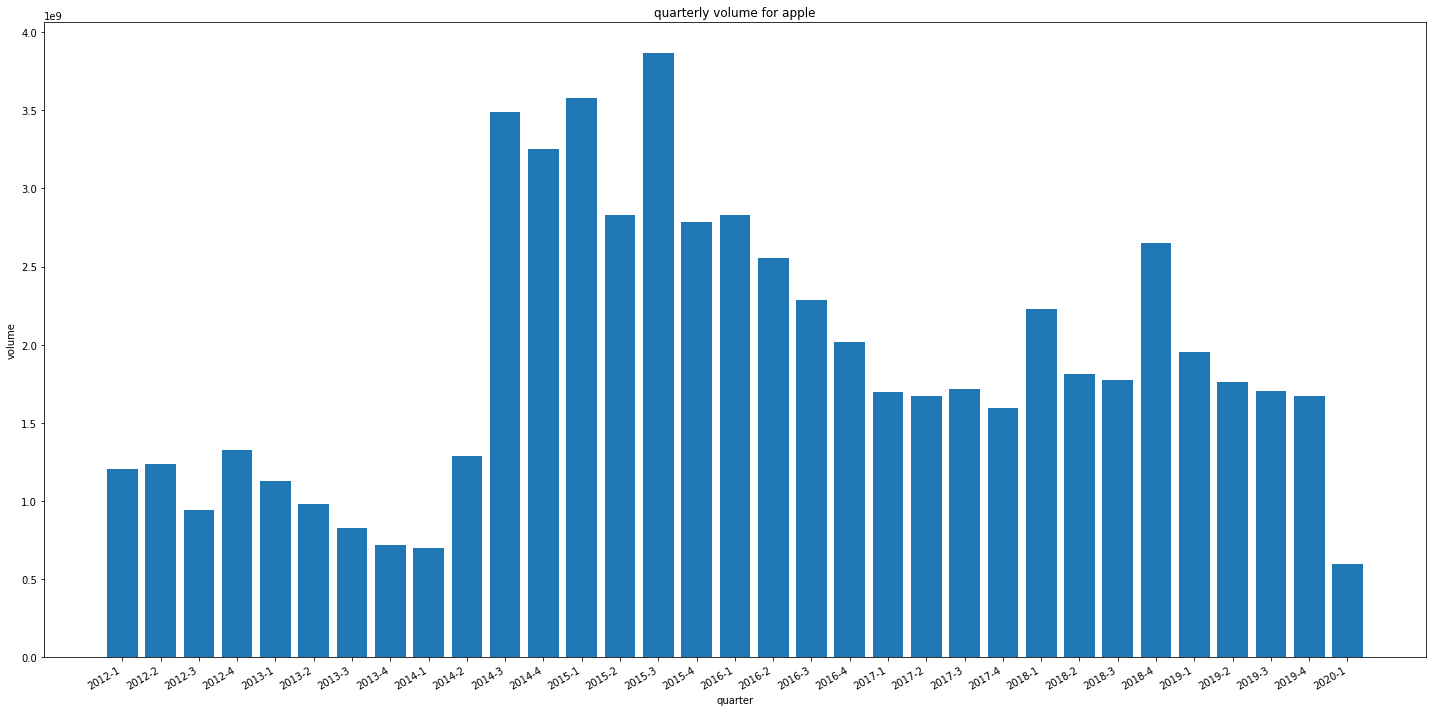

In [ ]:
stocks_dataframe['date'] = pd.to_datetime(stocks_dataframe['date']) 
stocks_dataframe['quarter'] = stocks_dataframe['date'].dt.to_period('Q')
res = stocks_dataframe.groupby([stocks_dataframe.date.dt.quarter, stocks_dataframe.date.dt.year]).sum("volume")
res = res.rename_axis(['quarter', 'year'])
res.reset_index(inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
# Setting labels & titles
ax.set_xlabel('quarter')
ax.set_ylabel('volume')
plt.title('quarterly volume for apple')
res = res.astype({"quarter": str, "year": str})
res["date"] = res["year"] + "-" + res["quarter"]
res = res.sort_values(by="date")
# res['date'] = pd.to_datetime(res['date'])
ax.bar(res['date'], res["volume"])
# date_format = mpl_dates.DateFormatter('%Y')
# ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

# The quarterly mean of close price of apple stocks in the markets

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


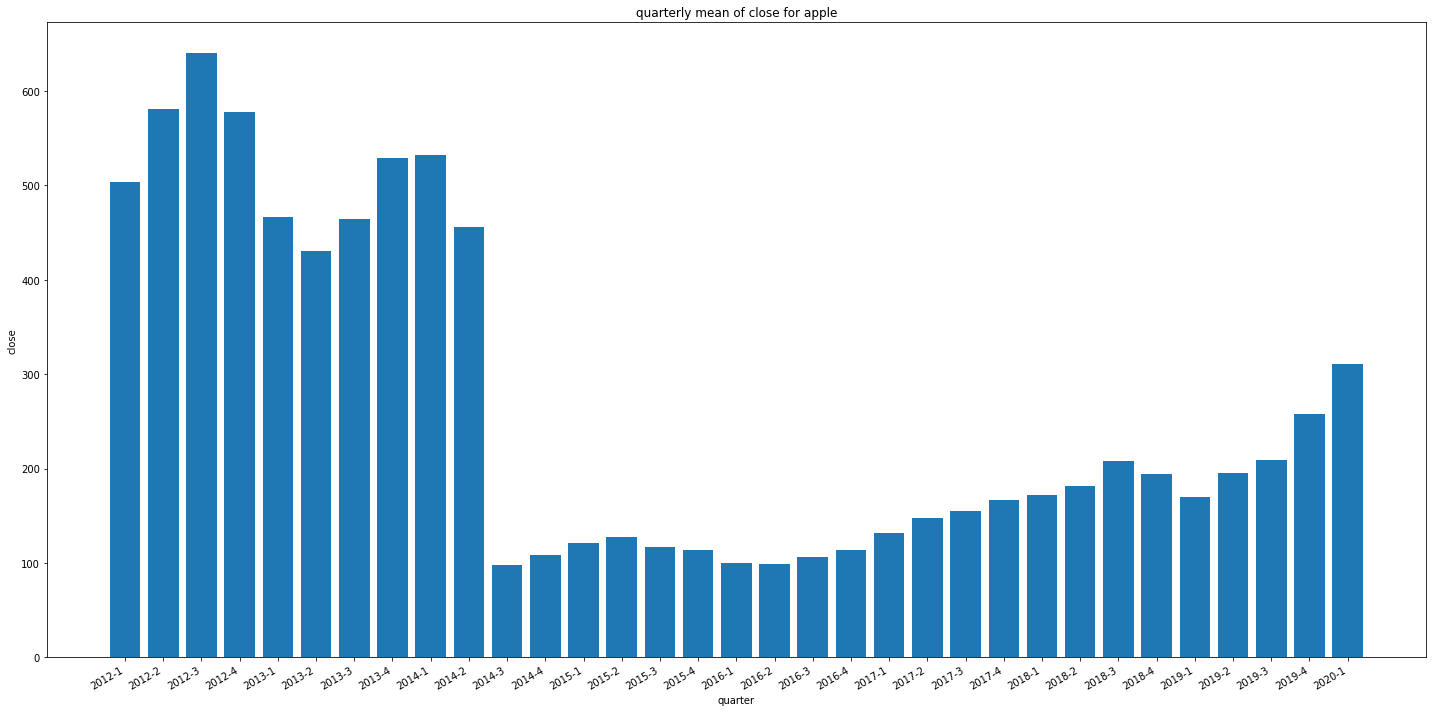

In [ ]:
stocks_dataframe['date'] = pd.to_datetime(stocks_dataframe['date']) 
stocks_dataframe['quarter'] = stocks_dataframe['date'].dt.to_period('Q')
res = stocks_dataframe.groupby([stocks_dataframe.date.dt.quarter, stocks_dataframe.date.dt.year]).mean("close")
res = res.rename_axis(['quarter', 'year'])
res.reset_index(inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
ax.set_xlabel('quarter')
ax.set_ylabel('close')
plt.title('quarterly mean of close for apple')
res = res.astype({"quarter": str, "year": str})
res["date"] = res["year"] + "-" + res["quarter"]
res = res.sort_values(by="date")
ax.bar(res['date'], res["close"])
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

# Combine stocks dataframe with news dataframe

In [ ]:
apple_news_dataframe = apple_news_dataframe.rename(columns={'release_date':'date'})
apple_news_dataframe['date'] = pd.to_datetime(apple_news_dataframe['date']) 
apple_all_news_stocks = pd.merge(stocks_dataframe, apple_news_dataframe, on="date")
apple_all_news_stocks[["date", "stocks_diff", "category", "title", "content", "provider", "url"]]

,date,stocks_diff,category,title,content,provider,url
0,2012-07-16,1.94,opinion,Waiting For Direction On The Markets,This stock market has been a difficult one for...,Cam Hui,https://www.investing.com/analysis/waiting-for...
1,2012-07-19,8.06,opinion,Mid Year Update U S And Canadian Stock Marke...,From 2004 to 2010 the TSX 300 Index of leading...,Baskin Financial Blog,https://www.investing.com/analysis/mid-year-up...
2,2012-07-23,-0.47,opinion,Trade Apple After Earnings,It may look like a spider web but the mishmas...,Abigail Doolittle,https://www.investing.com/analysis/trade-apple...
3,2012-07-23,-0.47,opinion,Summer Heat Scorches Europe And U S,Europe flares as summer heat continues Summer...,John Nyaradi,https://www.investing.com/analysis/summer-heat...
4,2012-07-23,-0.47,opinion,Apple Earnings Preview Quarterly Dip On Deck,Last quarter Apple AAPL reported the 2nd bes...,David Dyer,https://www.investing.com/analysis/apple-earni...
...,...,...,...,...,...,...,...
17643,2020-01-28,8.74,opinion,The Zacks Analyst Blog Highlights Merck Broa...,For Immediate ReleaseChicago IL January 28 ...,Zacks Investment Research,https://www.investing.com/analysis/the-zacks-a...
17644,2020-01-28,8.74,news,Stocks Dow Rebounds as Apple Rallies Into Ea...,By Yasin Ebrahim \nInvesting com The Dow ra...,Investing.com,https://www.investing.com/news/stock-market-ne...
17645,2020-01-28,8.74,news,Apple earnings 4 99 per share vs 4 55 EPS ...,Apple reported revenue and profit significantl...,CNBC,https://invst.ly/po2ao
17646,2020-01-28,8.74,news,Apple Earnings Beat in Q1 as iPhone Growth Ret...,By Yasin Ebrahim \nInvesting com Apple NASD...,Investing.com,https://www.investing.com/news/stock-market-ne...


# The number of news about leading companies in the market. 

In 2012- 2020 there were **221563** headlines about different companies including Apple, Microsoft, and Amazon. Apple company had the largest number of headlines with **20231** news divided into:  

**News (35.3%)-** Main providers of news were (in order): Reuters, Investing.com, Seeking Alpha, Bloomberg, CNBC, The Motley Fool, International Business Times, and MarketWatch.

**Opinion (64.7%)** – Main opinion providers were


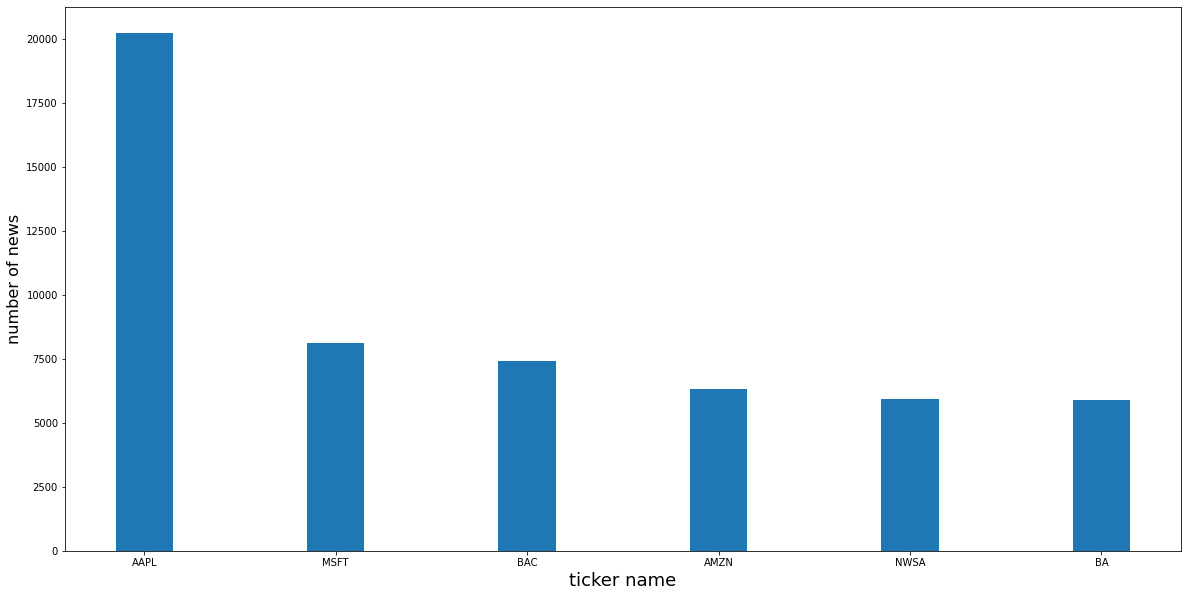

In [ ]:
tickers = news_dataframe["ticker"].value_counts()[:6].index.values
counts = news_dataframe["ticker"].value_counts()[:6].values
fig1, ax1 = plt.subplots()
fig1.set_size_inches((20, 10))
ax1.bar(height=counts, x=np.arange(len(counts)), tick_label=tickers, width=0.3)
plt.xlabel('ticker name', fontsize=18)
plt.ylabel('number of news', fontsize=16)
plt.show()

# Show percentage of news or opinions 


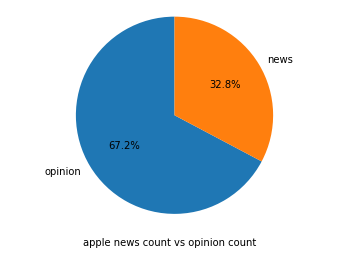

In [ ]:
types = apple_news_dataframe["category"].value_counts().index.values
counts = apple_news_dataframe["category"].value_counts().values
fig1, ax1 = plt.subplots()
ax1.pie(counts, labels=types, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
fig1.text(.5, .05, "apple news count vs opinion count", ha='center')
plt.show()

# Comparing between news and opinions if its positive or negative

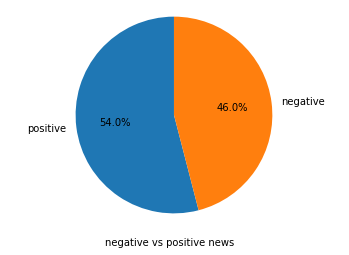

In [ ]:
fig1, ax1 = plt.subplots()
ax1.pie((apple_all_news_stocks[apple_all_news_stocks["category"] == "news"]["stocks_diff"] > 0).value_counts().values, labels=["positive", "negative"], autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
fig1.text(.5, .05, "negative vs positive news", ha='center')
plt.show()

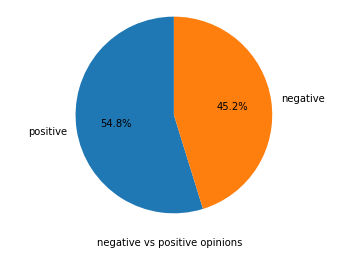

In [ ]:
fig1, ax1 = plt.subplots()
ax1.pie((apple_all_news_stocks[apple_all_news_stocks["category"] == "opinion"]["stocks_diff"] > 0).value_counts().values, labels=["positive", "negative"], autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
fig1.text(.5, .05, "negative vs positive opinions", ha='center')
plt.show()

#yearly number of news

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
No handles with labels found to put in legend.


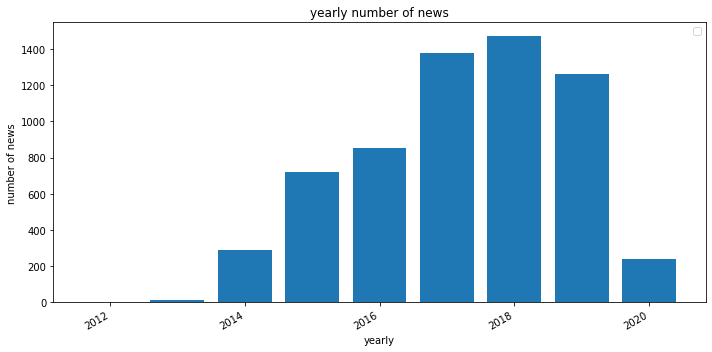

In [ ]:
apple_news_stocks = apple_all_news_stocks[apple_all_news_stocks["category"] == "news"]
apple_news_stocks['date'] = pd.to_datetime(apple_news_stocks['date']) 
res = pd.DataFrame(apple_news_stocks.groupby([apple_news_stocks.date.dt.year]).size())
res.columns = ["count"]
res.reset_index(inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches((10, 5))
ax.set_xlabel('yearly')
ax.set_ylabel('number of news')
plt.title('yearly number of news')
res = res.sort_values(by="date")
ax.bar(res['date'], res["count"])
plt.legend(loc="upper right")
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

#quarterly number of news

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


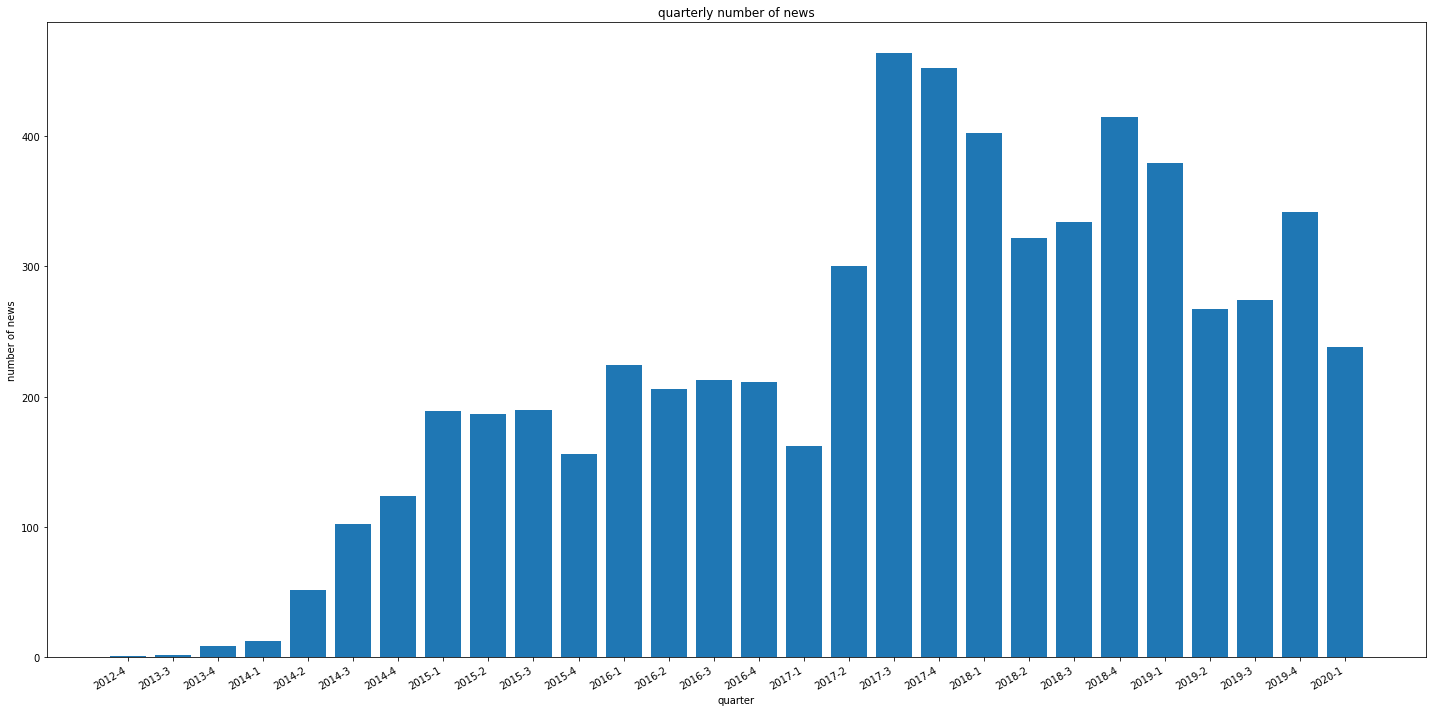

In [ ]:
apple_news_stocks['date'] = pd.to_datetime(apple_news_stocks['date']) 
apple_news_stocks['quarter'] = apple_news_stocks['date'].dt.to_period('Q')
res = pd.DataFrame(apple_news_stocks.groupby([apple_news_stocks.date.dt.quarter, apple_news_stocks.date.dt.year]).size())
res.columns = ["count"]
res = res.rename_axis(['quarter', 'year'])
res.reset_index(inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
ax.set_xlabel('quarter')
ax.set_ylabel('number of news')
plt.title('quarterly number of news')
res = res.astype({"quarter": str, "year": str})
res["date"] = res["year"] + "-" + res["quarter"]
res = res.sort_values(by="date")
ax.bar(res['date'], res["count"])
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

# The number of news for each source

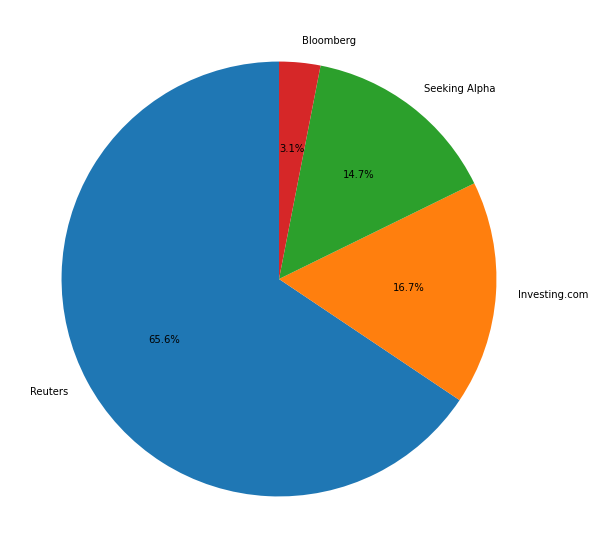

In [ ]:
providers = apple_news_stocks["provider"].value_counts()[apple_news_stocks["provider"].value_counts() >100].index.values
counts = apple_news_stocks["provider"].value_counts()[apple_news_stocks["provider"].value_counts() >100].values
fig1, ax1 = plt.subplots()
fig1.set_size_inches((20, 10))
ax1.pie(counts,  labels=providers, autopct='%1.1f%%', startangle=90)
# ax1.set_xlabel('provider')
# ax1.set_ylabel('number of news')
plt.show()

# Each source giving either positive or negative news

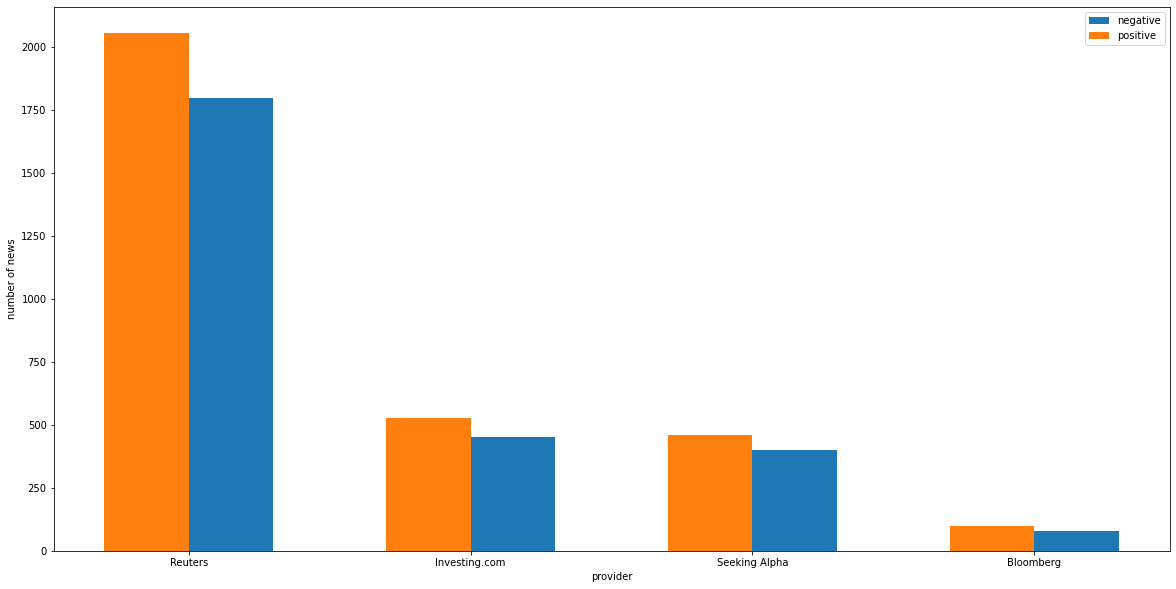

In [ ]:
positive = []
negative = []
for provider in providers:
  state = (apple_news_stocks[apple_news_stocks["provider"] == provider]["stocks_diff"] > 0).value_counts().index.values
  count = (apple_news_stocks[apple_news_stocks["provider"] == provider]["stocks_diff"] > 0).value_counts().values

  i=0 
  for s in state:
    if s:
      positive.append(count[i])
    else:
      negative.append(count[i])
    i+=1

fig1, ax1 = plt.subplots()
fig1.set_size_inches((20, 10))
ax1.bar(height=negative, x=np.arange(len(providers)), align='edge', width=0.3, label="negative")
ax1.bar(height=positive, x=np.arange(len(providers)), tick_label=providers, align='edge', width=-0.3, label="positive")
plt.legend(loc="upper right")
ax1.set_xlabel('provider')
ax1.set_ylabel('number of news')
plt.show()

# Top positively effictive news sources and how many effictive news each source have

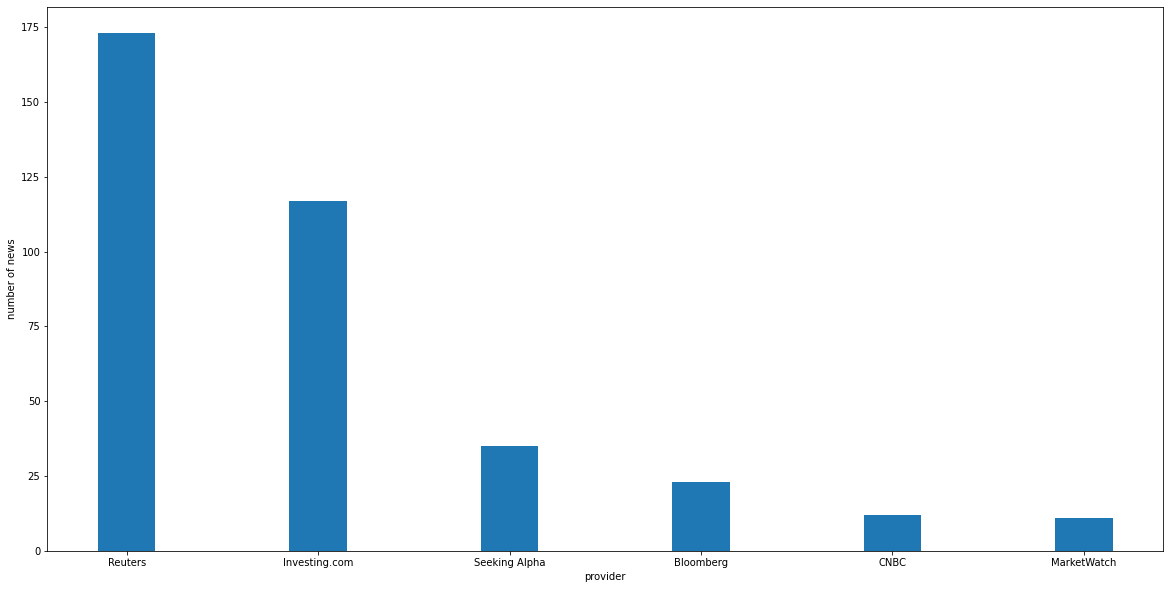

In [ ]:
positive_most_effictive = apple_all_news_stocks[(apple_all_news_stocks["category"] == "news") & (apple_all_news_stocks["stocks_diff"] > 5)]
providers = positive_most_effictive["provider"].value_counts().index.values[:6]


fig1, ax1 = plt.subplots()
fig1.set_size_inches((20, 10))
ax1.bar(height=positive_most_effictive["provider"].value_counts().values[:6], tick_label=providers, x=np.arange(len(providers)), align='center', width=0.3)
ax1.set_xlabel('provider')
ax1.set_ylabel('number of news')
plt.show()

# Top negatively effictive news sources and how many effictive news each source have

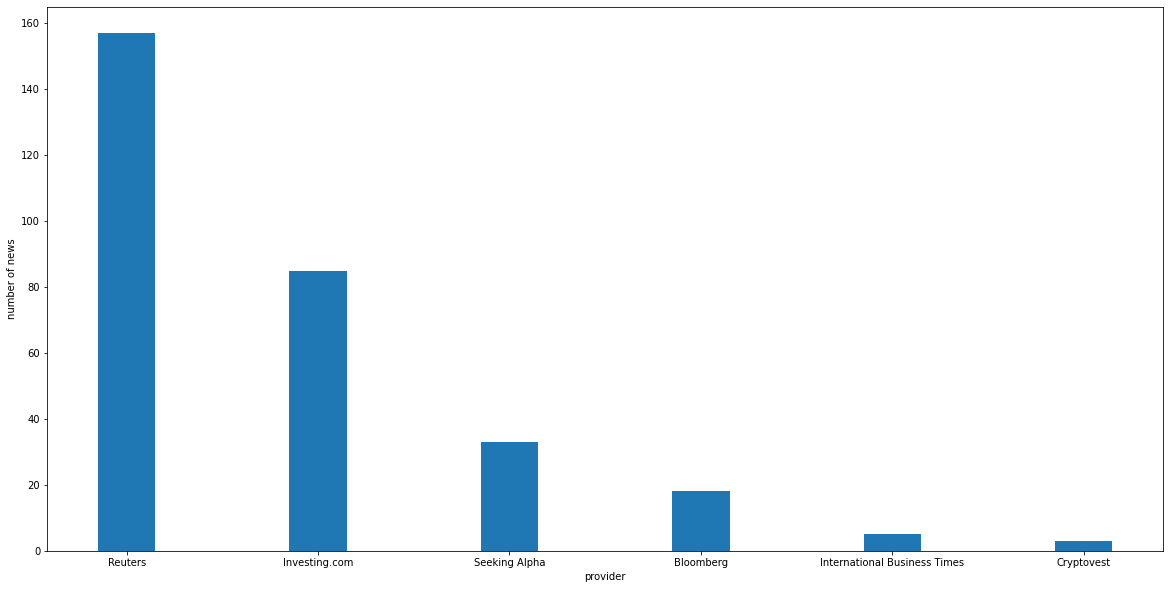

In [ ]:
negative_most_effictive = apple_all_news_stocks[(apple_all_news_stocks["category"] == "news") & (apple_all_news_stocks["stocks_diff"] < -5)]
providers = negative_most_effictive["provider"].value_counts().index.values[:6]


fig1, ax1 = plt.subplots()
fig1.set_size_inches((20, 10))
ax1.bar(height=negative_most_effictive["provider"].value_counts().values[:6], tick_label=providers, x=np.arange(len(providers)), align='center', width=0.3)
ax1.set_xlabel('provider')
ax1.set_ylabel('number of news')
plt.show()

#quarterly number of positive or negative news

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

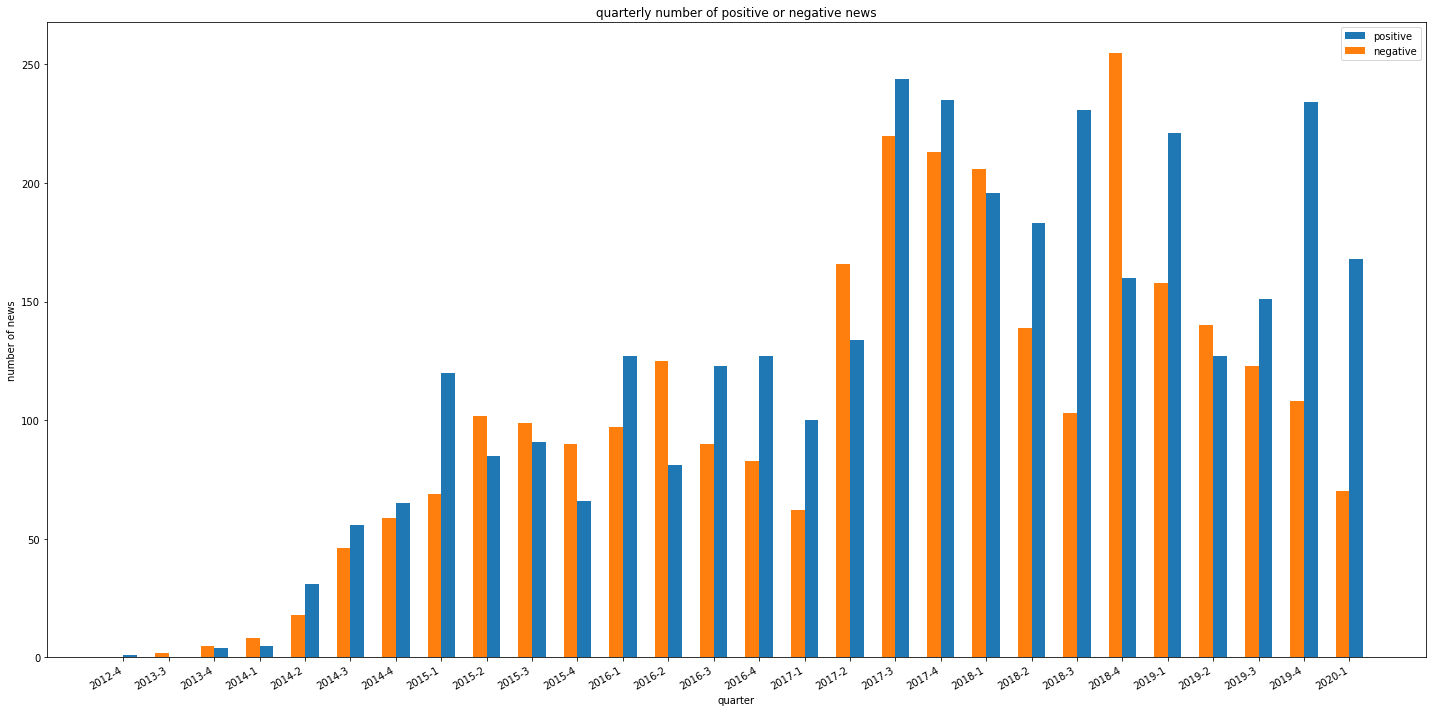

In [ ]:
apple_news_stocks["positive"] = apple_news_stocks["stocks_diff"] > 0
apple_news_stocks["negative"] = apple_news_stocks["stocks_diff"] < 0

apple_news_stocks['date'] = pd.to_datetime(apple_news_stocks['date']) 
apple_news_stocks['quarter'] = apple_news_stocks['date'].dt.to_period('Q')
res = apple_news_stocks.groupby([apple_news_stocks.date.dt.quarter, apple_news_stocks.date.dt.year]).sum(["positive", "negative"])
res = res.rename_axis(['quarter', 'year'])
res.reset_index(inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
ax.set_xlabel('quarter')
ax.set_ylabel('number of news')
plt.title('quarterly number of positive or negative news')
res = res.astype({"quarter": str, "year": str})
res["date"] = res["year"] + "-" + res["quarter"]
res = res.sort_values(by="date")
ax.bar(res['date'], res["positive"], align="edge", width=0.3, label="positive")
ax.bar(res["date"], res['negative'], align="edge", width=-0.3, label="negative")
plt.legend(loc="upper right")
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

#yearly number of opinions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
No handles with labels found to put in legend.


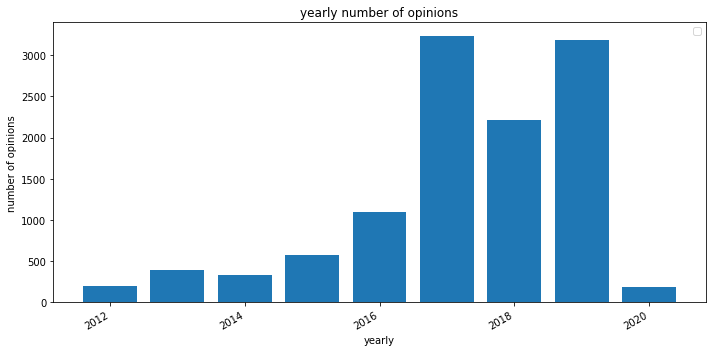

In [ ]:
apple_opinion_stocks = apple_all_news_stocks[apple_all_news_stocks["category"] == "opinion"]
apple_opinion_stocks['date'] = pd.to_datetime(apple_opinion_stocks['date']) 
res = pd.DataFrame(apple_opinion_stocks.groupby([apple_opinion_stocks.date.dt.year]).size())
res.columns = ["count"]
res.reset_index(inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches((10, 5))
ax.set_xlabel('yearly')
ax.set_ylabel('number of opinions')
plt.title('yearly number of opinions')
res = res.sort_values(by="date")
ax.bar(res['date'], res["count"])
plt.legend(loc="upper right")
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

#quarterly number of opinions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


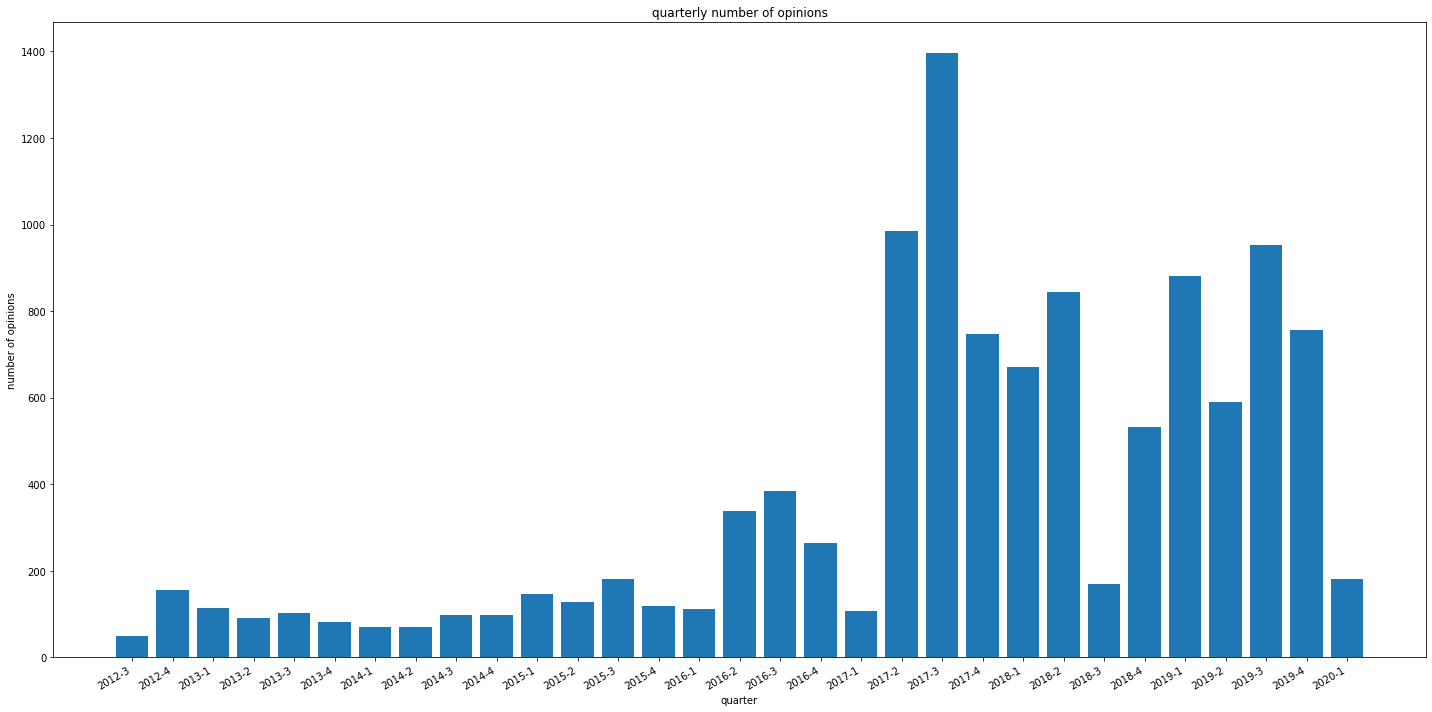

In [ ]:
apple_opinion_stocks['date'] = pd.to_datetime(apple_opinion_stocks['date']) 
apple_opinion_stocks['quarter'] = apple_opinion_stocks['date'].dt.to_period('Q')
res = pd.DataFrame(apple_opinion_stocks.groupby([apple_opinion_stocks.date.dt.quarter, apple_opinion_stocks.date.dt.year]).size())
res.columns = ["count"]
res = res.rename_axis(['quarter', 'year'])
res.reset_index(inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
ax.set_xlabel('quarter')
ax.set_ylabel('number of opinions')
plt.title('quarterly number of opinions')
res = res.astype({"quarter": str, "year": str})
res["date"] = res["year"] + "-" + res["quarter"]
res = res.sort_values(by="date")
ax.bar(res['date'], res["count"])
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

# Each influencer and his number of articles 

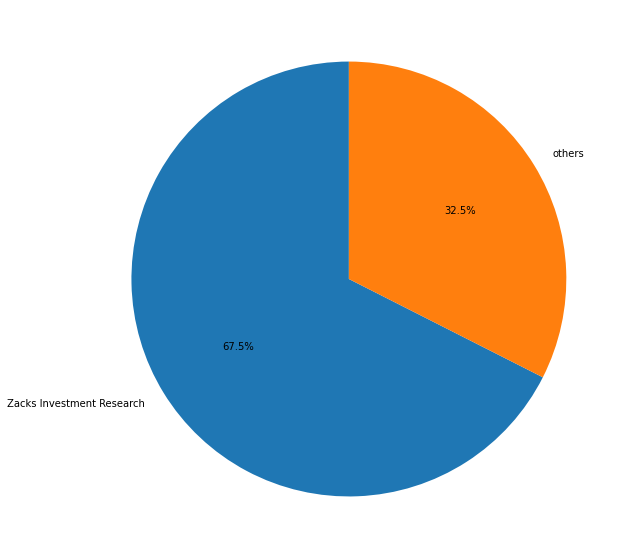

In [ ]:
providers = apple_opinion_stocks["provider"].value_counts().index.values
providers = [apple_opinion_stocks["provider"].value_counts().index.values[0], "others"]
apple_opinion_stocks["provider"].value_counts().sum()

counts = [apple_opinion_stocks["provider"].value_counts().values[0], apple_opinion_stocks["provider"].value_counts().sum() - apple_opinion_stocks["provider"].value_counts().values[0]]

fig1, ax1 = plt.subplots()
fig1.set_size_inches((20, 10))
ax1.pie(counts, labels=providers, autopct='%1.1f%%', startangle=90)
# ax1.set_xlabel('provider')
# ax1.set_ylabel('number of news')
plt.show()

# Each influencer has positive or negative news. 

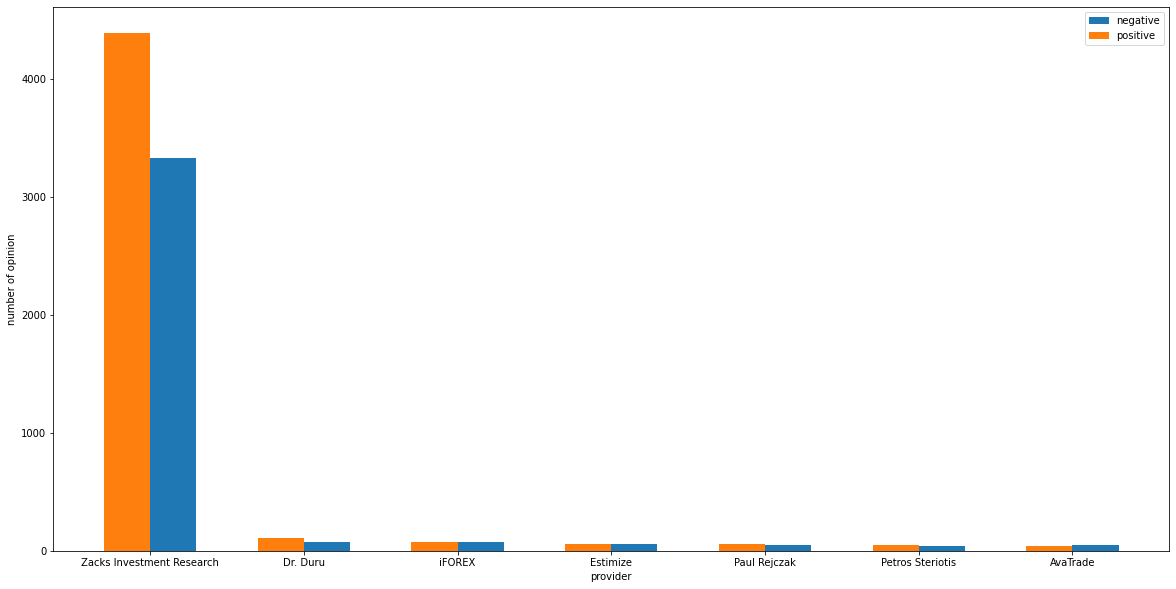

In [ ]:
apple_opinion_stocks = apple_all_news_stocks[apple_all_news_stocks["category"] == "opinion"]
providers = apple_opinion_stocks["provider"].value_counts()[apple_opinion_stocks["provider"].value_counts() >90].index.values
positive = []
negative = []
for provider in providers:
  state = (apple_opinion_stocks[apple_opinion_stocks["provider"] == provider]["stocks_diff"] > 0).value_counts().index.values
  count = (apple_opinion_stocks[apple_opinion_stocks["provider"] == provider]["stocks_diff"] > 0).value_counts().values

  i=0 
  for s in state:
    if s:
      positive.append(count[i])
    else:
      negative.append(count[i])
    i+=1

fig1, ax1 = plt.subplots()
fig1.set_size_inches((20, 10))
ax1.bar(height=negative, x=np.arange(len(providers)), align='edge', width=0.3, label="negative")
ax1.bar(height=positive, x=np.arange(len(providers)), tick_label=providers, align='edge', width=-0.3, label="positive")
plt.legend(loc="upper right")
ax1.set_xlabel('provider')
ax1.set_ylabel('number of opinion')
plt.show()

# Top positivley effictive opinions and how many effictive opinion each source have

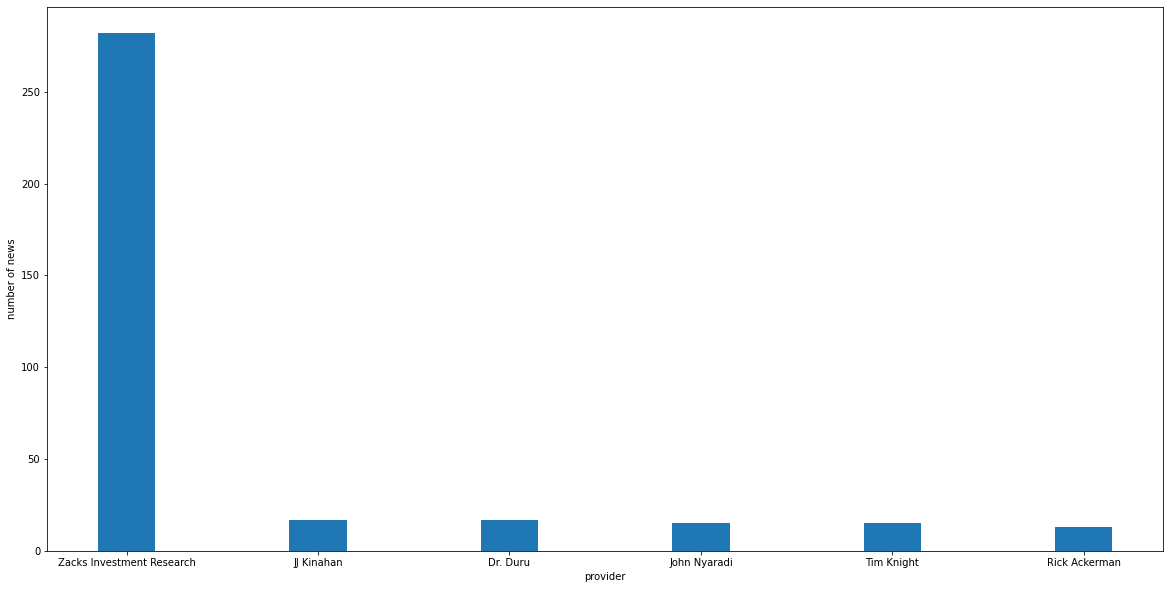

In [ ]:
negative_most_effictive = apple_all_news_stocks[(apple_all_news_stocks["category"] == "opinion") & (apple_all_news_stocks["stocks_diff"] > 5)]
providers = negative_most_effictive["provider"].value_counts().index.values[:6]


fig1, ax1 = plt.subplots()
fig1.set_size_inches((20, 10))
ax1.bar(height=negative_most_effictive["provider"].value_counts().values[:6], tick_label=providers, x=np.arange(len(providers)), align='center', width=0.3)
ax1.set_xlabel('provider')
ax1.set_ylabel('number of news')
plt.show()

# Top negatively effictive opinions and how many effictive opinion each source have

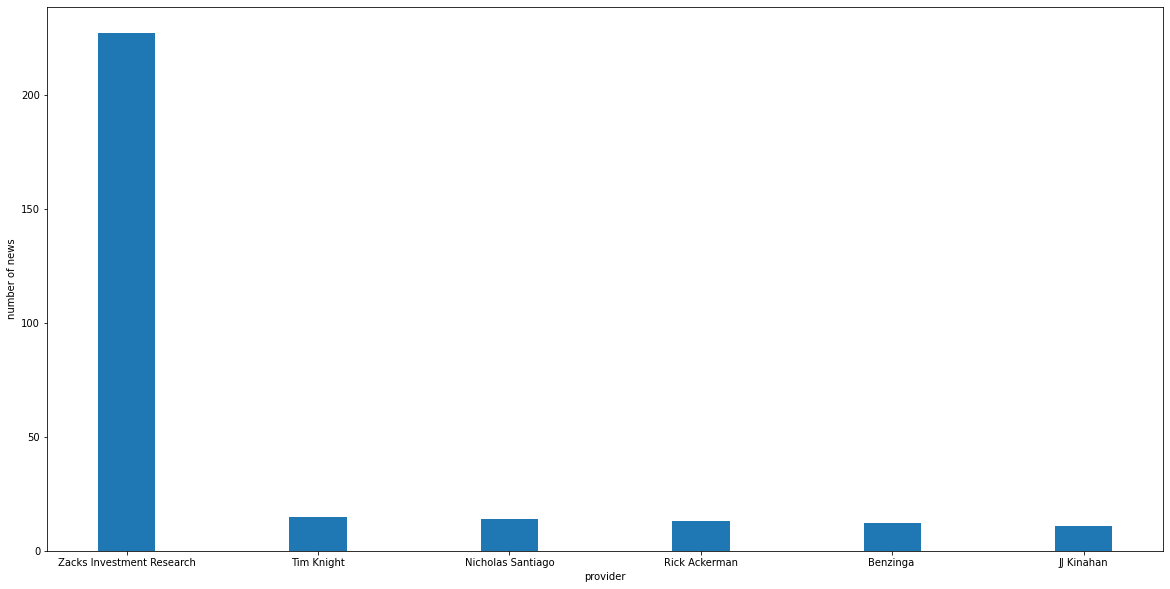

In [ ]:
negative_most_effictive = apple_all_news_stocks[(apple_all_news_stocks["category"] == "opinion") & (apple_all_news_stocks["stocks_diff"] < -5)]
providers = negative_most_effictive["provider"].value_counts().index.values[:6]


fig1, ax1 = plt.subplots()
fig1.set_size_inches((20, 10))
ax1.bar(height=negative_most_effictive["provider"].value_counts().values[:6], tick_label=providers, x=np.arange(len(providers)), align='center', width=0.3)
ax1.set_xlabel('provider')
ax1.set_ylabel('number of news')
plt.show()

#quarterly number of positive or negative opinions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

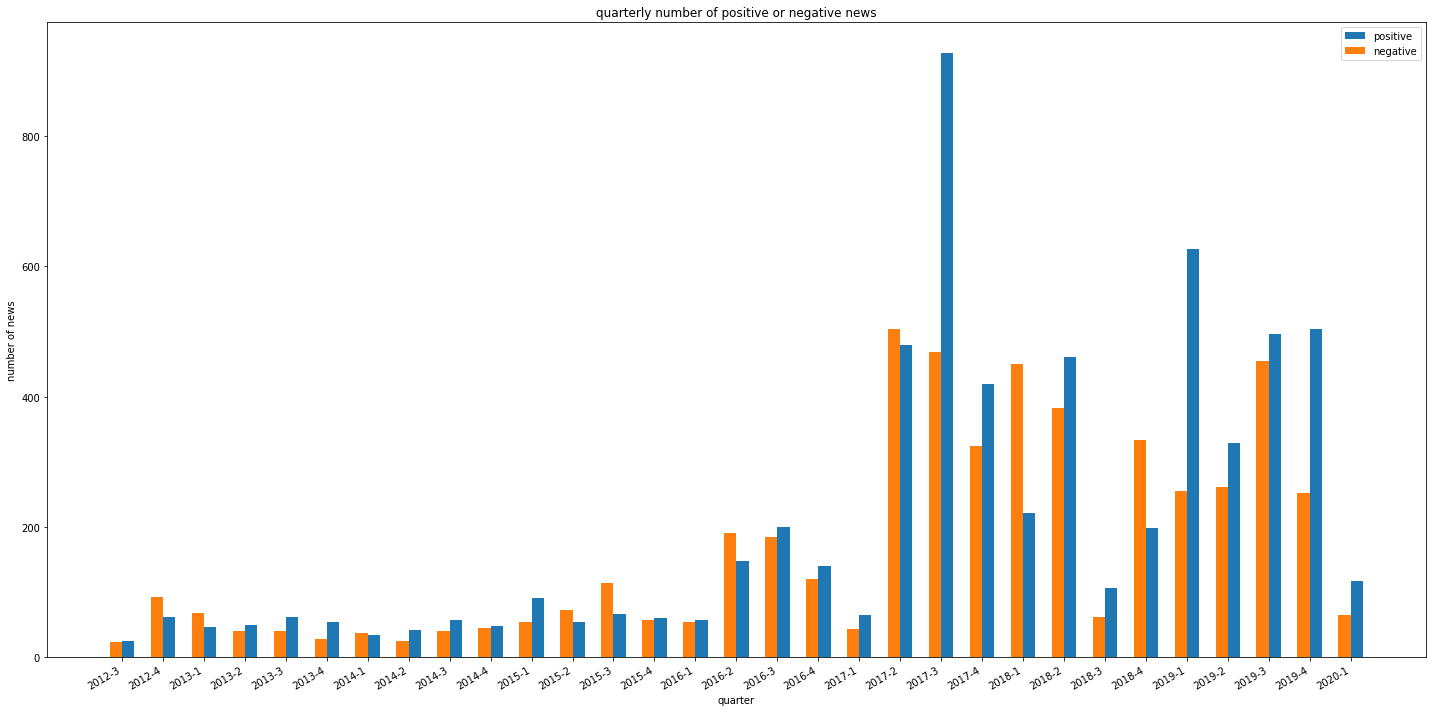

In [ ]:

apple_opinion_stocks["positive"] = apple_opinion_stocks["stocks_diff"] > 0
apple_opinion_stocks["negative"] = apple_opinion_stocks["stocks_diff"] < 0

apple_opinion_stocks['date'] = pd.to_datetime(apple_opinion_stocks['date']) 
apple_opinion_stocks['quarter'] = apple_opinion_stocks['date'].dt.to_period('Q')
res = apple_opinion_stocks.groupby([apple_opinion_stocks.date.dt.quarter, apple_opinion_stocks.date.dt.year]).sum(["positive", "negative"])
res = res.rename_axis(['quarter', 'year'])
res.reset_index(inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
ax.set_xlabel('quarter')
ax.set_ylabel('number of news')
plt.title('quarterly number of positive or negative news')
res = res.astype({"quarter": str, "year": str})
res["date"] = res["year"] + "-" + res["quarter"]
res = res.sort_values(by="date")
ax.bar(res['date'], res["positive"], align="edge", width=0.3, label="positive")
ax.bar(res["date"], res['negative'], align="edge", width=-0.3, label="negative")
plt.legend(loc="upper right")
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

#quarterly number of positive or negative news and opinions

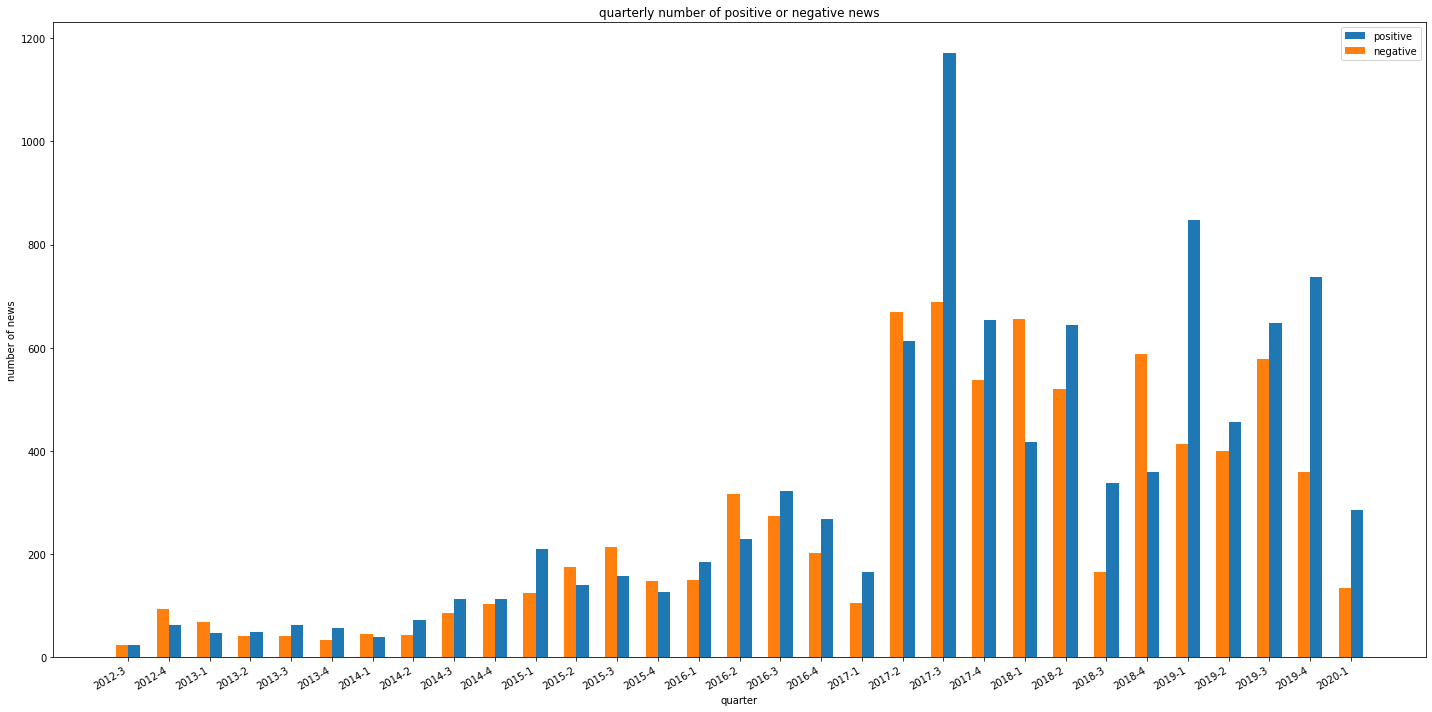

In [ ]:
apple_all_news_stocks["positive"] = apple_all_news_stocks["stocks_diff"] > 0
apple_all_news_stocks["negative"] = apple_all_news_stocks["stocks_diff"] < 0

apple_all_news_stocks['date'] = pd.to_datetime(apple_all_news_stocks['date']) 
apple_all_news_stocks['quarter'] = apple_all_news_stocks['date'].dt.to_period('Q')
res = apple_all_news_stocks.groupby([apple_all_news_stocks.date.dt.quarter, apple_all_news_stocks.date.dt.year]).sum(["positive", "negative"])
res = res.rename_axis(['quarter', 'year'])
res.reset_index(inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
ax.set_xlabel('quarter')
ax.set_ylabel('number of news')
plt.title('quarterly number of positive or negative news')
res = res.astype({"quarter": str, "year": str})
res["date"] = res["year"] + "-" + res["quarter"]
res = res.sort_values(by="date")
ax.bar(res['date'], res["positive"], align="edge", width=0.3, label="positive")
ax.bar(res["date"], res['negative'], align="edge", width=-0.3, label="negative")
plt.legend(loc="upper right")
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

# The quarterly prices increase or decrease in apple stock

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


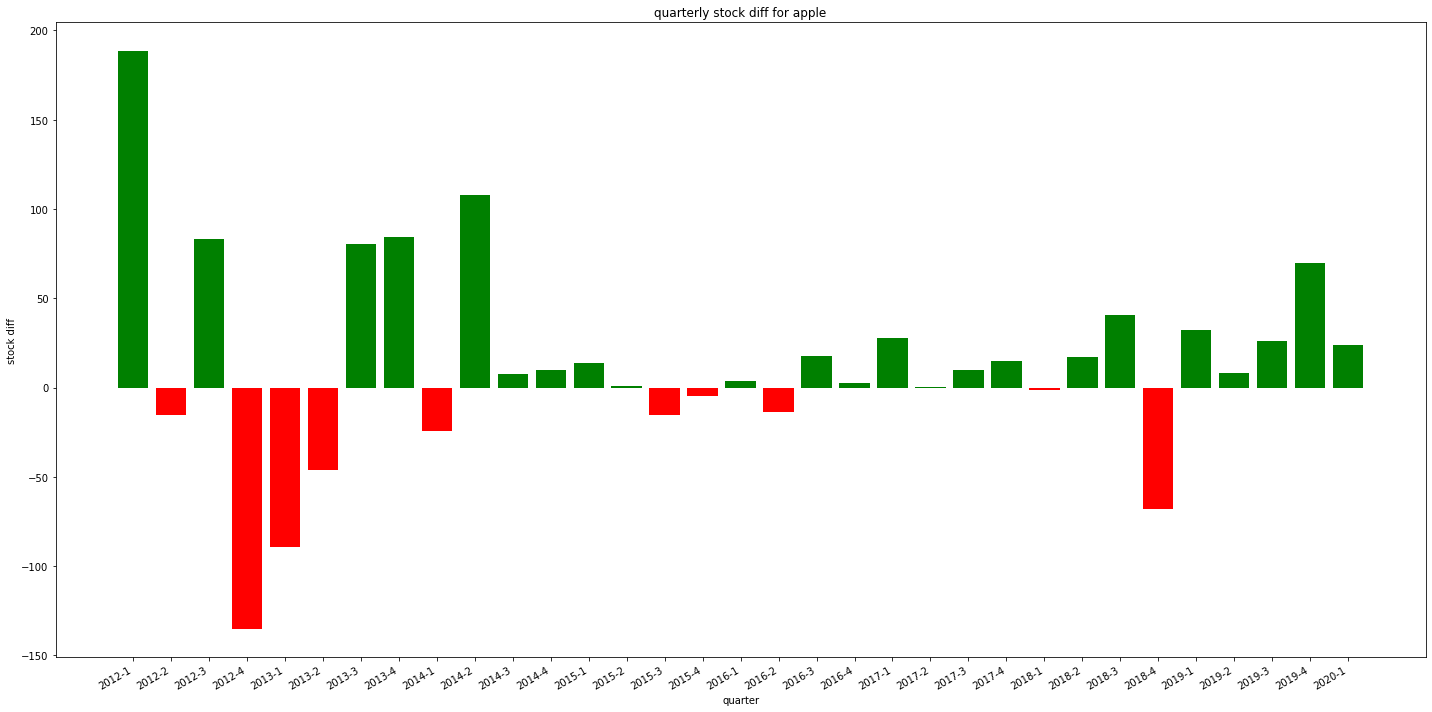

In [ ]:
stocks_dataframe['date'] = pd.to_datetime(stocks_dataframe['date']) 
stocks_dataframe['quarter'] = stocks_dataframe['date'].dt.to_period('Q')
res = stocks_dataframe.groupby([stocks_dataframe.date.dt.quarter, stocks_dataframe.date.dt.year]).sum("stocks_diff")
res = res.rename_axis(['quarter', 'year'])
res.reset_index(inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
# Setting labels & titles
ax.set_xlabel('quarter')
ax.set_ylabel('stock diff')
plt.title('quarterly stock diff for apple')
res = res.astype({"quarter": str, "year": str})
res["date"] = res["year"] + "-" + res["quarter"]
res = res.sort_values(by="date")
# res['date'] = pd.to_datetime(res['date'])
color = (res["stocks_diff"] > 0).map({True: 'g', False: 'r'})
ax.bar(res['date'], res["stocks_diff"], color=color)
# date_format = mpl_dates.DateFormatter('%Y')
# ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

In [ ]:
apple_all_news_stocks.head()

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,...,id,ticker,title,category,content,provider,url,article_id,positive,negative
0,2012-07-16,606.91,611.62,605.02,605.12,10759300,18.581432,18.725636,18.523567,18.526629,...,290924,AAPL,Waiting For Direction On The Markets,opinion,This stock market has been a difficult one for...,Cam Hui,https://www.investing.com/analysis/waiting-for...,129680.0,True,False
1,2012-07-19,614.32,615.35,606.00,611.28,15602200,18.808300,18.839835,18.553571,18.715226,...,290925,AAPL,Mid Year Update U S And Canadian Stock Marke...,opinion,From 2004 to 2010 the TSX 300 Index of leading...,Baskin Financial Blog,https://www.investing.com/analysis/mid-year-up...,130056.0,True,False
2,2012-07-23,603.83,605.90,587.71,594.40,17427700,18.487134,18.550510,17.993596,18.198420,...,290928,AAPL,Trade Apple After Earnings,opinion,It may look like a spider web but the mishmas...,Abigail Doolittle,https://www.investing.com/analysis/trade-apple...,130440.0,False,True
3,2012-07-23,603.83,605.90,587.71,594.40,17427700,18.487134,18.550510,17.993596,18.198420,...,290926,AAPL,Summer Heat Scorches Europe And U S,opinion,Europe flares as summer heat continues Summer...,John Nyaradi,https://www.investing.com/analysis/summer-heat...,130439.0,False,True
4,2012-07-23,603.83,605.90,587.71,594.40,17427700,18.487134,18.550510,17.993596,18.198420,...,290927,AAPL,Apple Earnings Preview Quarterly Dip On Deck,opinion,Last quarter Apple AAPL reported the 2nd bes...,David Dyer,https://www.investing.com/analysis/apple-earni...,130458.0,False,True


In [ ]:
apple_all_news_stocks.content[1]

'From 2004 to 2010 the TSX 300 Index of leading Canadian stocks outperformed the S P 500 Index of major American companies in each and every year  Canadian investors did much better than their American counterparts  and to add icing to the cake  the Canadian dollar rose steadily from about 78 cents US in 2004 to over par in 2010  It was a great time to be in Canadian stocks  Nothing lasts forever  as we all know  and things changed in 2011  The TSX had a poor year  falling 11   while the S P 500 was flat  That trend has continued in the first half of 2012  The TSX was down 3  for the six months ended June 30  while the S P 500 rose about 8  The biggest winners in the US so far this year were in the technology area  a sector which has almost disappeared from the Canadian market with the diminishment of Research in Motion  RIMM   Apple  AAPL  became the most valuable company in the world and giants such as Oracle  ORCL   Microsoft  MSFT  and IBM  IBM  did very well  driving up stock pric

In [ ]:
# import string
# string.punctuation
# #defining the function to remove punctuation
# def remove_punctuation(text):
#     punctuationfree="".join([i for i in text if i not in string.punctuation])
#     return punctuationfree
# #storing the puntuation free text
# apple_all_news_stocks['clean_content']= apple_all_news_stocks['content'].apply(lambda x:remove_punctuation(x))
# apple_all_news_stocks['clean_content']= apple_all_news_stocks['clean_content'].apply(lambda x: x.lower())

# #defining function for tokenization
# import re
# def tokenization(text):
#     tokens = re.split('\s+',text)
#     return tokens
# #applying function to the column
# apple_all_news_stocks['clean_content']= apple_all_news_stocks['clean_content'].apply(lambda x: tokenization(x))
# #importing nlp library
# import nltk
# #Stop words present in the library
# nltk.download('stopwords')
# stopwords = nltk.corpus.stopwords.words('english')
# #defining the function to remove stopwords from tokenized text
# def remove_stopwords(text):
#     output= [i for i in text if i not in stopwords]
#     return output

# #applying the function
# apple_all_news_stocks['clean_content']= apple_all_news_stocks['clean_content'].apply(lambda x:remove_stopwords(x))

# from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
# #defining the object for Lemmatization
# wordnet_lemmatizer = WordNetLemmatizer()


# #defining the function for lemmatization
# def lemmatizer(text):
#   lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
#   return lemm_text
# apple_all_news_stocks['clean_content']=apple_all_news_stocks['clean_content'].apply(lambda x:lemmatizer(x))
# print ([i + 1 for i, s in enumerate(apple_all_news_stocks.clean_content[0]) if s == "opinion"])

In [ ]:
# #convert to lowercase, strip and remove punctuations
# def preprocess(text):
#     text = text.lower() 
#     text=text.strip()  
#     text=re.compile('<.*?>').sub('', text) 
#     text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
#     text = re.sub('\s+', ' ', text)  
#     text = re.sub(r'\[[0-9]*\]',' ',text) 
#     text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
#     text = re.sub(r'\d',' ',text) 
#     text = re.sub(r'\s+',' ',text) 
#     return text

 
# # STOPWORD REMOVAL
# def stopword(string):
#     a= [i for i in string.split() if i not in stopwords.words('english')]
#     return ' '.join(a)
# #LEMMATIZATION
# # Initialize the lemmatizer
# wl = WordNetLemmatizer()
 
# # This is a helper function to map NTLK position tags
# def get_wordnet_pos(tag):
#     if tag.startswith('J'):
#         return wordnet.ADJ
#     elif tag.startswith('V'):
#         return wordnet.VERB
#     elif tag.startswith('N'):
#         return wordnet.NOUN
#     elif tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN
# # Tokenize the sentence
# def lemmatizer(string):
#     word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
#     a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
#     return " ".join(a)

In [ ]:
apple_all_news_stocks.head()

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,...,id,ticker,title,category,content,provider,url,article_id,positive,negative
0,2012-07-16,606.91,611.62,605.02,605.12,10759300,18.581432,18.725636,18.523567,18.526629,...,290924,AAPL,Waiting For Direction On The Markets,opinion,This stock market has been a difficult one for...,Cam Hui,https://www.investing.com/analysis/waiting-for...,129680.0,True,False
1,2012-07-19,614.32,615.35,606.00,611.28,15602200,18.808300,18.839835,18.553571,18.715226,...,290925,AAPL,Mid Year Update U S And Canadian Stock Marke...,opinion,From 2004 to 2010 the TSX 300 Index of leading...,Baskin Financial Blog,https://www.investing.com/analysis/mid-year-up...,130056.0,True,False
2,2012-07-23,603.83,605.90,587.71,594.40,17427700,18.487134,18.550510,17.993596,18.198420,...,290928,AAPL,Trade Apple After Earnings,opinion,It may look like a spider web but the mishmas...,Abigail Doolittle,https://www.investing.com/analysis/trade-apple...,130440.0,False,True
3,2012-07-23,603.83,605.90,587.71,594.40,17427700,18.487134,18.550510,17.993596,18.198420,...,290926,AAPL,Summer Heat Scorches Europe And U S,opinion,Europe flares as summer heat continues Summer...,John Nyaradi,https://www.investing.com/analysis/summer-heat...,130439.0,False,True
4,2012-07-23,603.83,605.90,587.71,594.40,17427700,18.487134,18.550510,17.993596,18.198420,...,290927,AAPL,Apple Earnings Preview Quarterly Dip On Deck,opinion,Last quarter Apple AAPL reported the 2nd bes...,David Dyer,https://www.investing.com/analysis/apple-earni...,130458.0,False,True


In [ ]:
def clean(text):
  # Removes all special characters and numericals leaving the alphabets
  text = re.sub('[^A-Za-z]+', ' ', text)
  return text
apple_all_news_stocks['cleaned_content'] = apple_all_news_stocks['content'].apply(clean)


In [ ]:
nltk.download("omw-1.4")

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')

from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
  tags = pos_tag(word_tokenize(text))
  newlist = []
  for word, tag in tags:
    if word.lower() not in set(stopwords.words('english')):
        newlist.append(tuple([word, pos_dict.get(tag[0])]))
  return newlist

apple_all_news_stocks['cleaned_content'] = apple_all_news_stocks['cleaned_content'].apply(token_stop_pos)
apple_all_news_stocks.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,...,ticker,title,category,content,provider,url,article_id,positive,negative,cleaned_content
0,2012-07-16,606.91,611.62,605.02,605.12,10759300,18.581432,18.725636,18.523567,18.526629,...,AAPL,Waiting For Direction On The Markets,opinion,This stock market has been a difficult one for...,Cam Hui,https://www.investing.com/analysis/waiting-for...,129680.0,True,False,"[(stock, n), (market, n), (difficult, a), (one..."
1,2012-07-19,614.32,615.35,606.00,611.28,15602200,18.808300,18.839835,18.553571,18.715226,...,AAPL,Mid Year Update U S And Canadian Stock Marke...,opinion,From 2004 to 2010 the TSX 300 Index of leading...,Baskin Financial Blog,https://www.investing.com/analysis/mid-year-up...,130056.0,True,False,"[(TSX, n), (Index, n), (leading, v), (Canadian..."
2,2012-07-23,603.83,605.90,587.71,594.40,17427700,18.487134,18.550510,17.993596,18.198420,...,AAPL,Trade Apple After Earnings,opinion,It may look like a spider web but the mishmas...,Abigail Doolittle,https://www.investing.com/analysis/trade-apple...,130440.0,False,True,"[(may, None), (look, v), (like, None), (spider..."
3,2012-07-23,603.83,605.90,587.71,594.40,17427700,18.487134,18.550510,17.993596,18.198420,...,AAPL,Summer Heat Scorches Europe And U S,opinion,Europe flares as summer heat continues Summer...,John Nyaradi,https://www.investing.com/analysis/summer-heat...,130439.0,False,True,"[(Europe, n), (flares, v), (summer, n), (heat,..."
4,2012-07-23,603.83,605.90,587.71,594.40,17427700,18.487134,18.550510,17.993596,18.198420,...,AAPL,Apple Earnings Preview Quarterly Dip On Deck,opinion,Last quarter Apple AAPL reported the 2nd bes...,David Dyer,https://www.investing.com/analysis/apple-earni...,130458.0,False,True,"[(Last, a), (quarter, n), (Apple, n), (AAPL, n..."


In [ ]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
  lemma_rew = " "
  for word, pos in pos_data:
    if not pos:
      lemma = word
      lemma_rew = lemma_rew + " " + lemma
    else:
      lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
      lemma_rew = lemma_rew + " " + lemma
  return lemma_rew

apple_all_news_stocks['cleaned_content'] = apple_all_news_stocks['cleaned_content'].apply(lemmatize)
apple_all_news_stocks.head()

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,...,ticker,title,category,content,provider,url,article_id,positive,negative,cleaned_content
0,2012-07-16,606.91,611.62,605.02,605.12,10759300,18.581432,18.725636,18.523567,18.526629,...,AAPL,Waiting For Direction On The Markets,opinion,This stock market has been a difficult one for...,Cam Hui,https://www.investing.com/analysis/waiting-for...,129680.0,True,False,stock market difficult one trader investor a...
1,2012-07-19,614.32,615.35,606.00,611.28,15602200,18.808300,18.839835,18.553571,18.715226,...,AAPL,Mid Year Update U S And Canadian Stock Marke...,opinion,From 2004 to 2010 the TSX 300 Index of leading...,Baskin Financial Blog,https://www.investing.com/analysis/mid-year-up...,130056.0,True,False,TSX Index lead Canadian stock outperform P I...
2,2012-07-23,603.83,605.90,587.71,594.40,17427700,18.487134,18.550510,17.993596,18.198420,...,AAPL,Trade Apple After Earnings,opinion,It may look like a spider web but the mishmas...,Abigail Doolittle,https://www.investing.com/analysis/trade-apple...,130440.0,False,True,may look like spider web mishmash trendlines...
3,2012-07-23,603.83,605.90,587.71,594.40,17427700,18.487134,18.550510,17.993596,18.198420,...,AAPL,Summer Heat Scorches Europe And U S,opinion,Europe flares as summer heat continues Summer...,John Nyaradi,https://www.investing.com/analysis/summer-heat...,130439.0,False,True,Europe flare summer heat continue Summer hea...
4,2012-07-23,603.83,605.90,587.71,594.40,17427700,18.487134,18.550510,17.993596,18.198420,...,AAPL,Apple Earnings Preview Quarterly Dip On Deck,opinion,Last quarter Apple AAPL reported the 2nd bes...,David Dyer,https://www.investing.com/analysis/apple-earni...,130458.0,False,True,Last quarter Apple AAPL report nd best quart...


In [ ]:
from textblob import TextBlob
# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity
# function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [ ]:
# # fin_data['Subjectivity'] = fin_data['Lemma'].apply(getSubjectivity) 
# apple_all_news_stocks['Polarity'] = apple_all_news_stocks['cleaned_content'].apply(getPolarity) 
# apple_all_news_stocks['Analysis'] = apple_all_news_stocks['Polarity'].apply(analysis)
# apple_all_news_stocks.head()

In [ ]:
# apple_all_news_stocks["Analysis"].value_counts()

In [ ]:
# #import the TfidfVectorizer from Scikit-Learn.
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer(max_df=.65, min_df=1, stop_words=None, use_idf=True, norm=None)
# transformed_documents = vectorizer.fit_transform(apple_all_news_stocks["cleaned_content"])

In [ ]:
# transformed_documents.shape

In [ ]:
# transformed_documents_as_array = transformed_documents.toarray()
# # use this line of code to verify that the numpy array represents the same number of documents that we have in the file list
# len(transformed_documents_as_array)

In [ ]:
# from pathlib import Path

# tidf_output_path = "/content/tf_idf_output/"
# # make the output folder if it doesn't already exist
# Path(tidf_output_path).mkdir(parents=True, exist_ok=True)

# # construct a list of output file paths using the previous list of text files the relative path for tf_idf_output
# output_filenames = [tidf_output_path + str(i) + ".csv" for i in range(apple_all_news_stocks.shape[0])]

# # loop each item in transformed_documents_as_array, using enumerate to keep track of the current position
# for counter, doc in enumerate(transformed_documents_as_array):
#     # construct a dataframe
#     tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
#     one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)

#     # output to a csv using the enumerated value for the filename
#     one_doc_as_df.to_csv(output_filenames[counter])

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj = SentimentIntensityAnalyzer()

In [ ]:
apple_all_news_stocks['scores'] = apple_all_news_stocks['cleaned_content'].apply(lambda news: sid_obj.polarity_scores(str(news)))

In [ ]:
apple_all_news_stocks['compound'] = apple_all_news_stocks['scores'].apply(lambda score_dict: score_dict['compound'])
apple_all_news_stocks['sentiment_type'] = apple_all_news_stocks['compound'].apply(analysis)

In [ ]:
apple_all_news_stocks["sentiment_type"].value_counts()

Positive    15636
Negative     1940
Neutral        72
Name: sentiment_type, dtype: int64

In [ ]:
apple_all_news_stocks.to_csv('news.csv')

In [ ]:
apple_all_news_stocks.describe()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor,stocks_diff,article_id,compound
count,17648.000000,17648.000000,17648.000000,17648.000000,1.764800e+04,17648.000000,17648.000000,17648.000000,17648.000000,1.764800e+04,17648.000000,17648.000000,17648.000000,1.764800e+04,17648.000000
mean,184.158019,185.790155,182.360725,184.028820,3.521963e+07,39.341878,39.681183,38.965167,39.308088,1.597167e+08,0.006739,1.002040,0.212542,1.121235e+08,0.744339
std,87.702683,88.550147,86.720896,87.682659,1.920520e+07,12.790100,12.864591,12.671971,12.745221,1.157914e+08,0.089610,0.110616,4.060803,9.904457e+07,0.534294
min,90.280000,90.700000,89.470000,90.000000,5.798000e+06,12.132997,12.414784,11.964298,12.053463,4.544818e+07,0.000000,1.000000,-63.505000,1.296800e+05,-0.999300
25%,144.090000,145.720000,143.160100,143.980000,2.304048e+07,29.392000,29.666925,29.155700,29.423809,9.447186e+07,0.000000,1.000000,-1.010000,5.377970e+05,0.875000
50%,166.440000,168.500000,164.560000,166.110000,2.974270e+07,38.467714,39.060918,38.091304,38.322391,1.246736e+08,0.000000,1.000000,0.210000,2.001699e+08,0.985800
75%,200.020000,201.400000,198.170000,199.200000,4.134428e+07,45.999709,46.303042,45.513834,46.109274,1.794530e+08,0.000000,1.000000,1.720000,2.003178e+08,0.996200
max,699.781000,700.060000,694.610000,699.350000,1.895606e+08,78.638494,79.648480,78.217256,78.889759,1.460854e+09,3.290000,7.000007,43.020000,2.005024e+08,1.000000


In [ ]:
# function to analyze the reviews
def positive(score):
    if score < 0:
        return 0
    elif score == 0:
        return 0
    else:
        return 1

In [ ]:
# function to analyze the reviews
def negative(score):
    if score < 0:
        return 1
    elif score == 0:
        return 0
    else:
        return 0

In [ ]:
apple_all_news_stocks['positve'] = apple_all_news_stocks['compound'].apply(positive)
apple_all_news_stocks['negativ'] = apple_all_news_stocks['compound'].apply(negative)

In [ ]:
apple_all_news_stocks.head()

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,...,url,article_id,positive,negative,cleaned_content,scores,compound,sentiment_type,positve,negativ
0,2012-07-16,606.91,611.62,605.02,605.12,10759300,18.581432,18.725636,18.523567,18.526629,...,https://www.investing.com/analysis/waiting-for...,129680.0,True,False,stock market difficult one trader investor a...,"{'neg': 0.101, 'neu': 0.784, 'pos': 0.115, 'co...",0.7973,Positive,1,0
1,2012-07-19,614.32,615.35,606.00,611.28,15602200,18.808300,18.839835,18.553571,18.715226,...,https://www.investing.com/analysis/mid-year-up...,130056.0,True,False,TSX Index lead Canadian stock outperform P I...,"{'neg': 0.088, 'neu': 0.752, 'pos': 0.16, 'com...",0.9965,Positive,1,0
2,2012-07-23,603.83,605.90,587.71,594.40,17427700,18.487134,18.550510,17.993596,18.198420,...,https://www.investing.com/analysis/trade-apple...,130440.0,False,True,may look like spider web mishmash trendlines...,"{'neg': 0.059, 'neu': 0.796, 'pos': 0.145, 'co...",0.9451,Positive,1,0
3,2012-07-23,603.83,605.90,587.71,594.40,17427700,18.487134,18.550510,17.993596,18.198420,...,https://www.investing.com/analysis/summer-heat...,130439.0,False,True,Europe flare summer heat continue Summer hea...,"{'neg': 0.084, 'neu': 0.828, 'pos': 0.087, 'co...",0.0000,Neutral,0,0
4,2012-07-23,603.83,605.90,587.71,594.40,17427700,18.487134,18.550510,17.993596,18.198420,...,https://www.investing.com/analysis/apple-earni...,130458.0,False,True,Last quarter Apple AAPL report nd best quart...,"{'neg': 0.064, 'neu': 0.701, 'pos': 0.235, 'co...",0.9966,Positive,1,0


In [ ]:
sentiment_data = apple_all_news_stocks.groupby([apple_all_news_stocks.date]).agg({"positve": [np.sum], "negativ": [np.sum]})

In [ ]:
sentiment_data.head()

,NP,NN
Date,,
2012-07-16,1,0
2012-07-19,1,0
2012-07-23,2,0
2012-07-24,1,0
2012-07-27,1,0


In [ ]:
sentiment_data.shape

(1740, 2)

In [ ]:
stocks = pd.read_csv("/content/financial_news_project/stocks/AAPL.csv")

In [ ]:
sentiment_data.reset_index(inplace=True)
stocks.reset_index(inplace=True)

In [ ]:
sentiment_data.head()

,date,positve,negativ
,,sum,sum
0,2012-07-16,1,0
1,2012-07-19,1,0
2,2012-07-23,2,0
3,2012-07-24,1,0
4,2012-07-27,1,0


In [ ]:
sentiment_data.columns= ['Date', 'NP', 'NN']

In [ ]:
sentiment_data.dtypes

Date    datetime64[ns]
NP               int64
NN               int64
dtype: object

In [ ]:
stocks.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


In [ ]:
stocks.set_index('Date', inplace=True)

In [ ]:
sentiment_data.set_index('Date', inplace=True)

In [ ]:
stocks.Date = pd.to_datetime(stocks.Date)
sentiment_data.Date = pd.to_datetime(sentiment_data.Date)

AttributeError: ignored

In [ ]:
result = pd.merge(sentiment_data, stocks, how='outer', on='Date')

In [ ]:
result = result.sort_values(by="Date")

In [ ]:
# result['Date'] = pd.to_datetime(result['Date'], format="%Y-%m-%d")

In [ ]:
result

In [ ]:
result[result['Date'] > pd.to_datetime("2018-7-16",format='%Y-%m-%d')]

In [ ]:
result['NP'] = result['NP'].replace(np.nan, 0)
result['NN'] = result['NN'].replace(np.nan, 0)

In [ ]:
result = result.drop(["index"], axis=1)

In [ ]:
result.shape

In [ ]:
result.to_csv("/content/financial_news_project/apple_stocks_with_frequency_of_news.csv")